In [150]:
#Import
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
import ast
from scipy import stats
#from helpers import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from scipy.stats import ttest_1samp
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import levene
from scipy.stats import chi2_contingency
import networkx as nx

## 1) Data

### 1) a) Load Data

In [151]:
#Open Bechdel Test JSON object 
json_file_path = './Data/Bechdel_get_all.json'
with open(json_file_path, 'r') as file:
    json_data = json.load(file)

# Convert JSON to DataFrame
df_bech = pd.DataFrame(json_data)

#Show Bechdel Test DataFrame
print('Bechdel Test dataset has', len(df_bech), 'entries')
df_bech.head()

#Open Movie dataFrame
df = pd.read_csv('./Data/movie.metadata.tsv', names = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date',
                                                   'Movie box office revenue','Movie runtime','Movie languages (Freebase ID:name tuples)',
                                                   'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)'],sep='\t')
df['Movie release date']=pd.to_datetime(df['Movie release date'], format='%Y-%m-%d', errors='coerce')
df['year'] = df['Movie release date'].dt.year
# Display the first few rows of the dataframe
print('CMU Movies dataset has', len(df), 'entries')


Bechdel Test dataset has 10136 entries
CMU Movies dataset has 81741 entries


In [152]:
#Load the saved bechdel dataframe with wiki IDs
df_bech = pd.read_csv('./Data/df_bech_with_wikiID.csv')


In [153]:
#Load merged_df (containing the requested Production companies)
merged_df = pd.read_csv('merged_df.csv')
print('The merged Bechdel movie dataset has', len(merged_df), 'movies')
print(100*round((len(merged_df)/len(df_bech)),2),'% of Bechdel movies are in the merged dataset')

The merged Bechdel movie dataset has 5816 movies
56.99999999999999 % of Bechdel movies are in the merged dataset


### 1) b) Data representativeness

This first overview let us know the size of the two datasets across the years. This first analysis counts all movies, regardless of the possible missing values in the columns of the dataframe. 

In [154]:
fig = go.Figure()

# Bechdel
fig.add_trace(go.Scatter(x=df_bech.groupby('year').count().index,
                         y=df_bech.groupby('year').count()['id'],
                         mode='lines',
                         name='Bechdel',
                         line=dict(color='indigo')))

# CMU
fig.add_trace(go.Scatter(x=df.groupby('year').count().index,
                         y=df.groupby('year').count()['Movie name'],
                         mode='lines',
                         name='CMU',
                         line=dict(color='gray')))

# Update layout
fig.update_layout(xaxis=dict(title='Year'),
                  yaxis=dict(title='Number of Movies'),
                  title='Number of Movies in Bechdel and CMU Datasets Across the Years',
                  showlegend=True,
                  width=800,
                  height=400)

# Show the plot
fig.show(renderer="iframe")

Although the Bechdel test is about two 8 times smaller than CMU, it follows the same increasing trend with years. It appears that the CMU has no data after 2016, whereas Bechdel contains data until 2023. Thus, it won't be possible to perform analysis on the last five years. 

In [155]:

merged_df_percentages = merged_df['rating'].value_counts(normalize=True) * 100
df_bech_percentages = df_bech['rating'].value_counts(normalize=True) * 100

# Create DataFrames for Plotly
df_merged_ly = pd.DataFrame({'Rating': merged_df_percentages.index, 'Percentage': merged_df_percentages.values, 'Dataset': 'merged_df'})
df_bech_ly = pd.DataFrame({'Rating': df_bech_percentages.index, 'Percentage': df_bech_percentages.values, 'Dataset': 'df_bech'})

# Concatenate the DataFrames
df_combined = pd.concat([df_merged_ly, df_bech_ly])


# Create grouped bar plot using Plotly Express
fig = px.bar(df_combined, x='Rating', y='Percentage', color='Dataset',
             color_discrete_map={'merged_df': '#FFD700', 'df_bech': '#B19CD9'},
             labels={'Percentage': 'Percentage of Movies in the dataset'},
             title='Comparison of Movies by Rating between Bechdel dataset and Merged dataset',
             barmode='group',  # Set barmode to 'group' for grouped bars
             width=800, height=500)

# Show the plot
fig.show()

# Save the plot as an HTML file
fig.write_html('comparison_rating_bech_merged.html')

### 1) c) Amount of NaNs values

In [156]:
#Iterate over different columns of Bechdel dataset to check missing values:
for col in df_bech.columns:
    nan_rating_count = df_bech[col].isna().sum()
    print('Number of NaN values in column',col, nan_rating_count)

Number of NaN values in column Unnamed: 0 0
Number of NaN values in column imdbid 7
Number of NaN values in column year 0
Number of NaN values in column rating 0
Number of NaN values in column id 0
Number of NaN values in column title 0
Number of NaN values in column WikiID 73


No values are missing in the Bechdel dataset, which is expected, because this dataset is collaborative, and data get double checked before being published on the website.

In [157]:
#Iterate over columns of CMU movies dataset to check missing values:
for col in df.columns:
    nan_rating_count = df[col].isna().sum()
    print('Proportion of NaN values in column',col, round(100*(nan_rating_count/len(df)),2),'%')

Proportion of NaN values in column Wikipedia movie ID 0.0 %
Proportion of NaN values in column Freebase movie ID 0.0 %
Proportion of NaN values in column Movie name 0.0 %
Proportion of NaN values in column Movie release date 51.83 %
Proportion of NaN values in column Movie box office revenue 89.72 %
Proportion of NaN values in column Movie runtime 25.02 %
Proportion of NaN values in column Movie languages (Freebase ID:name tuples) 0.0 %
Proportion of NaN values in column Movie countries (Freebase ID:name tuples) 0.0 %
Proportion of NaN values in column Movie genres (Freebase ID:name tuples) 0.0 %
Proportion of NaN values in column year 51.83 %


We observe that there are no missing values in the Movie name column. Thus, we will not miss rows when performing the merge on this column. However, half of the dataset has missing release date, and the box office revenue is missing for about 90 % of the movies.

### 1) d) First Data vizualisation

#### Grade evolution across years

In [158]:
# Calculate the count of each rating per year
rating_counts = merged_df.groupby(['year_x', 'rating']).size().reset_index(name='count')

# Create a line plot with counts
fig = px.line(rating_counts, x='year_x', y='count',
              color='rating', labels={'year_x': 'Year', 'count': 'Count'},
              title='Count of Grades (0, 1, 2, 3) per Year',
              category_orders={'rating': [0, 1, 2, 3]},
              line_group='rating',
              width=800, height=400)

fig.update_xaxes(tickangle=45)

# Show the plot
fig.show(renderer="iframe")

In [159]:
# Class 0, 1, 2 as fail and 3 as pass
bech_pass = merged_df[merged_df['rating'] == 3]
bech_fail = merged_df[merged_df['rating'] < 3]

# Count Passing and failing per year
pass_year = bech_pass.groupby('year_x').count()['id'].reset_index()
fail_year = bech_fail.groupby('year_x').count()['id'].reset_index()

# Create a line plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=pass_year['year_x'], y=pass_year['id'], mode='lines', name='Pass', line=dict(color='green')))
fig.add_trace(go.Scatter(x=fail_year['year_x'], y=fail_year['id'], mode='lines', name='Fail', line=dict(color='red')))

fig.update_layout(xaxis=dict(title='Year'),
                  yaxis=dict(title='Count of movies/year'),
                  title='Evolution of the number of movies passing and failing the test across years in the merged dataset',
                  showlegend=True,
                  width=800,
                  height=400)

fig.show(renderer="iframe")

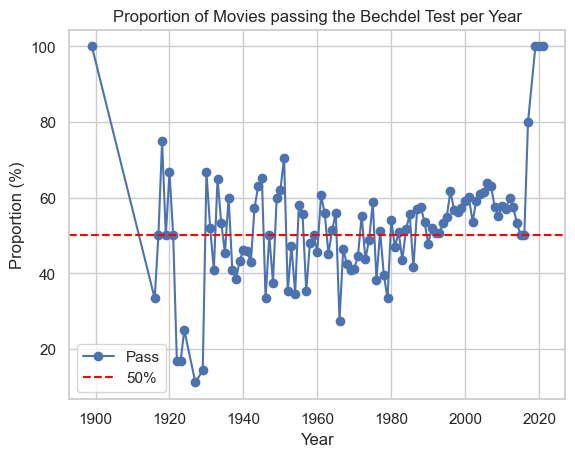

In [160]:
#Movie passing per year

merged_df['result'] = merged_df['rating'].apply(lambda x: 'Fail' if x in [0, 1, 2] else 'Pass')

# Group by 'year' and 'result', and calculate proportions
year_result_proportions = merged_df.groupby(['year_x', 'result']).size() / merged_df.groupby('year_x').size()

# Reset the index to make it a DataFrame
year_result_proportions = year_result_proportions.reset_index(name='proportion')

# Filter only the 'Pass' results
pass_proportions = year_result_proportions[year_result_proportions['result'] == 'Pass']

# Plotting
plt.plot(pass_proportions['year_x'], pass_proportions['proportion']*100, marker='o', label='Pass')
plt.axhline(y=50, color='red', linestyle='--', label='50%')
plt.xlabel('Year')
plt.ylabel('Proportion (%)')
plt.title('Proportion of Movies passing the Bechdel Test per Year')
plt.legend()
plt.show()

In [161]:
pass_fail = pd.merge(pass_year, fail_year, on='year_x', how='inner')

# Calculate the percentage of movies passing the test
pass_fail['percentage_pass'] = (pass_fail['id_x'] / (pass_fail['id_y'] + pass_fail['id_x'])) * 100
window_size = 10  # Adjust the window size as needed
pass_fail['rolling_std'] = pass_fail['percentage_pass'].rolling(window=window_size).std()
fig.add_trace(go.Scatter(x=pass_fail['year_x'], y=pass_fail['rolling_std'], mode='lines', name='Rolling Variance', line=dict(color='blue')))
fig = go.Figure()

fig.add_trace(go.Scatter(x=pass_fail['year_x'], y=pass_fail['rolling_std'], mode='lines', name='Rolling Variance', line=dict(color='blue')))

fig.update_layout(
    yaxis=dict(title='STDev'),
    title=f'Rolling STDev of Proportion of Movies Passing the Bechdel Test (Window Size: {window_size})',
    width=800, height=400
)

fig.show(renderer="iframe")

In [162]:
percentage_year = (pass_fail['id_x']/(pass_fail['id_y']+pass_fail['id_x']))*100
stats.spearmanr(pass_fail.index, percentage_year)

SignificanceResult(statistic=0.34108911560345156, pvalue=0.000550479598119025)

With the Spearman correlation results, we can conclude at the 0.5% confidence level that the percentage of films that pass the Bechdel test is correlated. We also see that there are some strange values in the early half of the 20th century, probably because there are less movies at this time so the percentages are less representative. In the future, we will likely get rid of years during which we have less than a certain threshold of movies.

In [163]:
rolling_std = pass_fail['percentage_pass'].rolling(window=window_size).std()

rolling_std = rolling_std.dropna()

In [164]:
stats.spearmanr(pass_fail.loc[rolling_std.dropna().index, 'year_x'], rolling_std)

SignificanceResult(statistic=-0.9047619047619047, pvalue=2.246617419947807e-34)

## 2) Movie Genres

Investigating movie genres is challenging, because a single movies may have mutiple genres. The genre column in the CMU dataset contains tuples. Thus we must first split the elements of the tuples to extract all genres.

### General analysis

In [165]:
# Convert the string representation of tuples to actual tuples
merged_df['genres'] = merged_df['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)

# Explode the 'genres' column to create separate rows for each genre tuple
merged_exploded = merged_df.explode('genres')
unique_ids_genre = merged_exploded['genres'].unique()

#List with IDs of the 20 most present genres in the merged dataset
top20_genres = merged_exploded.groupby('genres').count().sort_values(by='id',ascending=False).index[0:20]
top20_genres

#Filter Merged with top 20
top20_merged = merged_exploded[merged_exploded['genres'].isin(top20_genres)]

## Reduce Dimensionality of movies genres

In the orginal merged dataframe, we have 318 different movie genres. We aim at grouping genres sharing a same word, in order to group the sub-genres together. For example "Acid Western" and "Space Western" are subgenres of "Western" movies, and we will assign them both to genre "Western".

In [166]:
#Explore how diverse is the genre dataset, and how noisy it could be for future analysis
print('The merged dataframe contains',len(unique_ids_genre),'different genres')
print(len(merged_exploded.groupby('genres').count()[merged_exploded.groupby('genres').count()['id']==1]),'genres are in only 1 movie')

The merged dataframe contains 318 different genres
39 genres are in only 1 movie


In [167]:
#Function to assess if two genres share a common word (not taking into account generic words)
def share_common_word(genre1, genre2):
    #List to exclude: Stop words, and generic words
    list_exclude = ['and','&','drama', 'film', 'comedy','movie','movies','films','of','Movies','fiction','Cinema','thriller','Thriller','Adventure','cinema','New']
    words1 = set(genre1.lower().split())
    words2 = set(genre2.lower().split())
    shared_words = words1 & words2 - set(list_exclude)
    if shared_words:
        return True, shared_words.pop()  # Return True and the shared word
    else:
        return False, None

In [168]:
# Convert the string representation of tuples to actual dictionaries
merged_df['genres_dict'] = merged_df['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)

# Extract genre names from dictionaries
merged_df['genres_names'] = merged_df['genres_dict'].apply(
    lambda x: list(x.values()) if isinstance(x, dict) else []
)

# Use explode to convert lists into separate rows
exploded_df_names = merged_df.explode('genres_names')

# Get unique values from the 'genres' column
unique_genres_names = exploded_df_names['genres_names'].unique()

#Delete this value that is a nan
unique_genres_names = np.delete(unique_genres_names,159)

#Tuples that share words: produce list of (Genre1, Genre2, Common Word)
genre_share = []
i = 0
for genre1 in unique_genres_names:
      
    for genre2 in unique_genres_names:
        if genre1 != genre2:
            if share_common_word(genre1,genre2)[0]:
                genre_share.append([genre1,genre2,share_common_word(genre1,genre2)[1]])

genre_share = np.array(genre_share)

In [169]:
#Replace in merged_df the specific genres by the common wird they share 
k = 0
for genre_list in merged_df['genres_names']:
    k += 1
    flag = 0
    try:
        for i in range(len(genre_list)):
            indices = np.where((genre_list[i] == genre_share[:, 0]) | (genre_list[i] == genre_share[:, 1]))
            if indices[0].size > 0:
                flag = 1
                genre_list[i] = genre_share[indices[0][0], 2]
        if flag == 1:
            merged_df.at[k, 'genres_names'] = genre_list
    except ValueError as e:
        print(f"Error at index {k}: {e}")
        continue  # Continue with the next iteration
  

Error at index 5816: Must have equal len keys and value when setting with an iterable


In [170]:
# Convert the column to a list of unique values
unique_values = merged_df['genres_names'].explode().unique()

# Now, unique_values contains a list of all unique genre names
print(len(unique_values))

211


In [171]:
all_genres = merged_df['genres_names'].explode()

# Count the occurrences of each genre
genre_counts = all_genres.value_counts()

def filter_condition(genre_list):
    if isinstance(genre_list, list):
        return [genre for genre in genre_list if genre_counts.get(genre, 0) >= 15]
    else:
        return genre_list

# Apply the filter to the 'genres_names' column
merged_df['genres_names'] = merged_df['genres_names'].apply(filter_condition)

In [172]:
#Check how many different genres we have now
all_genre2 = merged_df['genres_names'].explode()
print(len(all_genre2.unique()))

131


In [173]:
#Save merged_df with reduced genres
merged_df.to_csv('merged_df_reduced_genres.csv', index=False)

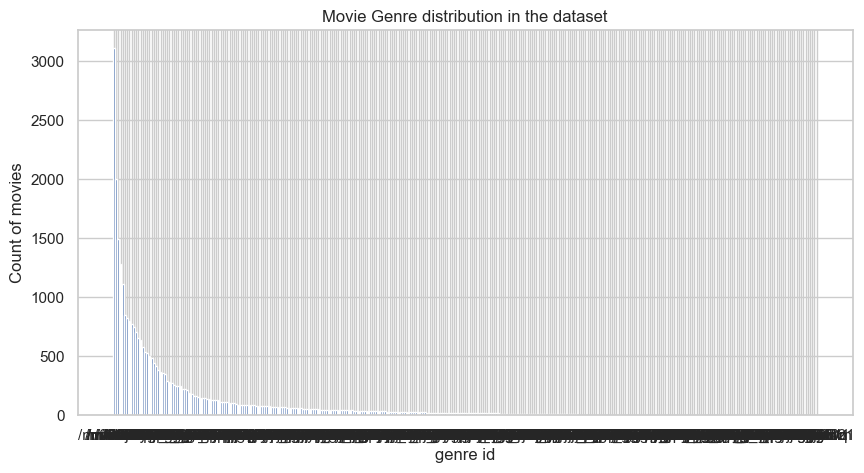

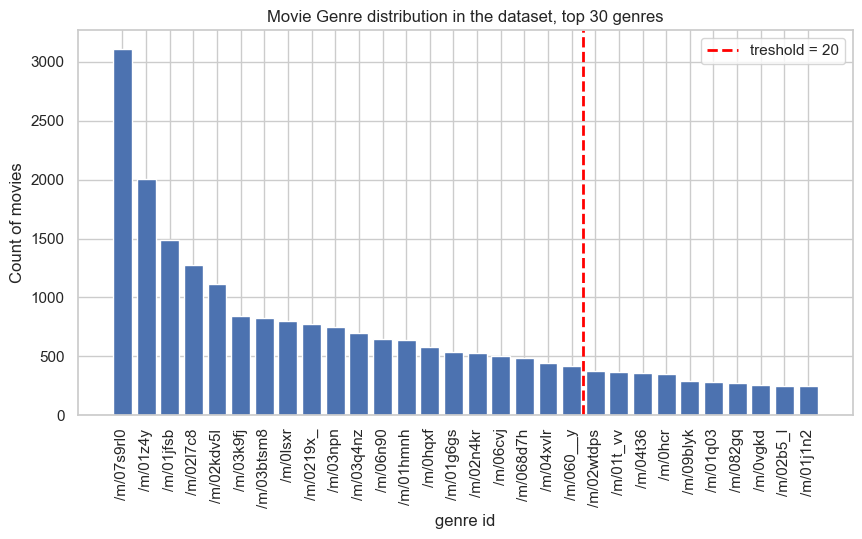

In [174]:
#Display genre distribution
plt.figure(figsize=(10,5))
plt.bar(merged_exploded.groupby('genres').count().sort_values(by='id',ascending=False).index,merged_exploded.groupby('genres').count().sort_values(by='id',ascending=False)['id'])
plt.xlabel('genre id')
plt.ylabel('Count of movies')
plt.title('Movie Genre distribution in the dataset')

plt.figure(figsize=(10,5))
plt.bar(merged_exploded.groupby('genres').count().sort_values(by='id',ascending=False).index[0:30],merged_exploded.groupby('genres').count().sort_values(by='id',ascending=False)['id'][0:30])
plt.xticks(rotation=90)
plt.xlabel('genre id')
plt.ylabel('Count of movies')
plt.title('Movie Genre distribution in the dataset, top 30 genres')
# Adding a vertical line after the 20th bar, ie the treshold we choose
plt.axvline(x=19.5, color='red', linestyle='--', linewidth=2, label='treshold = 20')  
plt.legend()
plt.show()

We will now focus on the top 20 most present genres

In [175]:
#Extract indexes of the top 20 genres
top20_genres = merged_exploded.groupby('genres').count().sort_values(by='id',ascending=False).index[0:20]
print(top20_genres)

Index(['/m/07s9rl0', '/m/01z4y', '/m/01jfsb', '/m/02l7c8', '/m/02kdv5l',
       '/m/03k9fj', '/m/03btsm8', '/m/0lsxr', '/m/0219x_', '/m/03npn',
       '/m/03q4nz', '/m/06n90', '/m/01hmnh', '/m/0hqxf', '/m/01g6gs',
       '/m/02n4kr', '/m/06cvj', '/m/068d7h', '/m/04xvlr', '/m/060__y'],
      dtype='object', name='genres')


In [176]:
#Genre IDs are not interpretable, we create a dictionnary with genre names associated to IDs
#This task could be done more efficiently in the future 
top20_dic = {"/m/01jfsb": "Thriller", "/m/03npn": "Horror",
             "/m/0lsxr":"Crime Fiction", "/m/03k9fj":"Adventure",
             "/m/07s9rl0":"Drama","/m/02l7c8":"Romance Film",
             "/m/01z4y":"Comedy","/m/03q4nz": "World cinema",
             "/m/03btsm8":"Action/Adventure","/m/02kdv5l":"Action",
            "/m/0219x_": "Indie",
            "/m/02n4kr": "Mystery","/m/06n90": "Science Fiction",
            "/m/01hmnh": "Fantasy","/m/0hqxf": "Family Film",
            "/m/01g6gs": "Black-and-white","/m/06cvj": "Romantic comedy",
            "/m/068d7h": "Romantic drama","/m/04xvlr": "Period piece",
            "/m/060__y": "Film adaptation"}

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/1332256229.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Genre distribution in the dataset, top 20 genres')

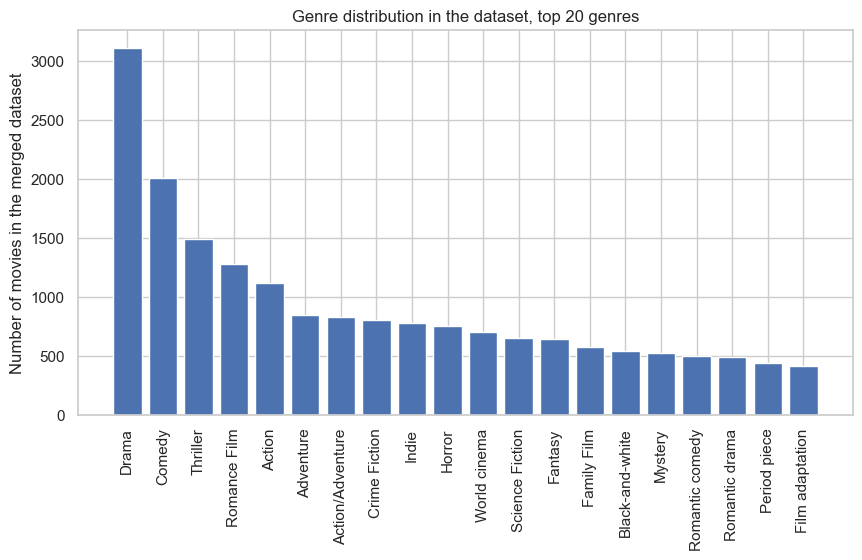

In [177]:
#Barplot showing the top 10 genres
top20_merged['genres'] = top20_merged['genres'].replace(top20_dic) #Assign genre names
plt.figure(figsize=(10,5))
plt.bar(top20_merged.groupby('genres').count().sort_values(by='id', ascending=False).index,
        top20_merged.groupby('genres').count().sort_values(by='id', ascending=False)['id'])
plt.xticks(rotation=90)
plt.ylabel('Number of movies in the merged dataset')
plt.title('Genre distribution in the dataset, top 20 genres')

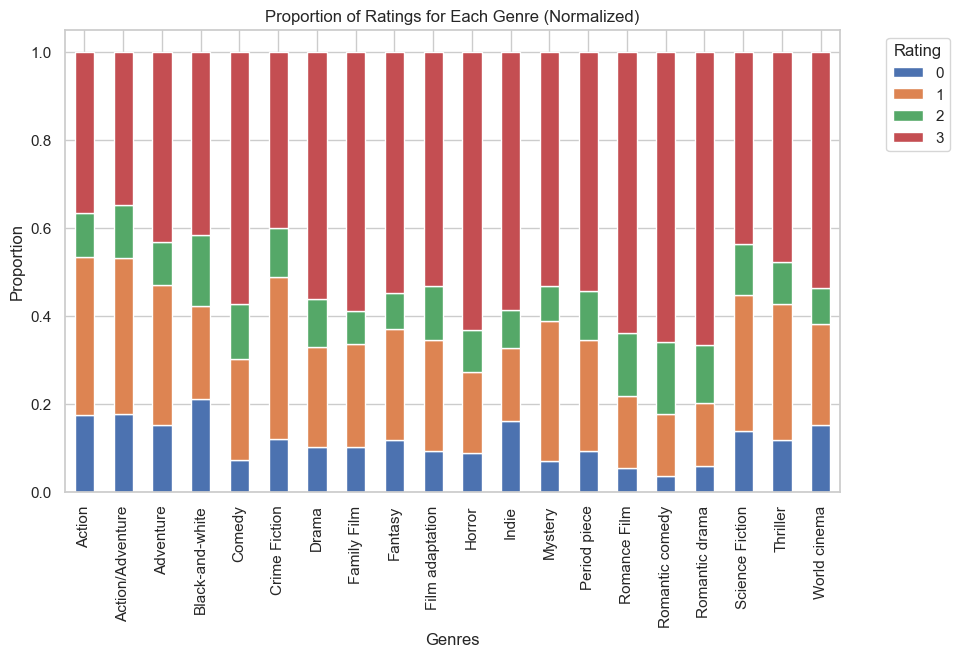

In [178]:
# Group by 'genres' and 'rating', and calculate proportions
genre_rating_proportions = top20_merged.groupby(['genres', 'rating']).size() / top20_merged.groupby('genres').size()

# Reset the index to make it a DataFrame
genre_rating_proportions = genre_rating_proportions.reset_index(name='proportion')

# Pivot the DataFrame to have 'rating' as columns
genre_rating_proportions_pivot = genre_rating_proportions.pivot(index='genres', columns='rating', values='proportion')

# Plotting
ax = genre_rating_proportions_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Proportion')
ax.set_xlabel('Genres')
ax.set_title('Proportion of Ratings for Each Genre (Normalized)')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/700710091.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



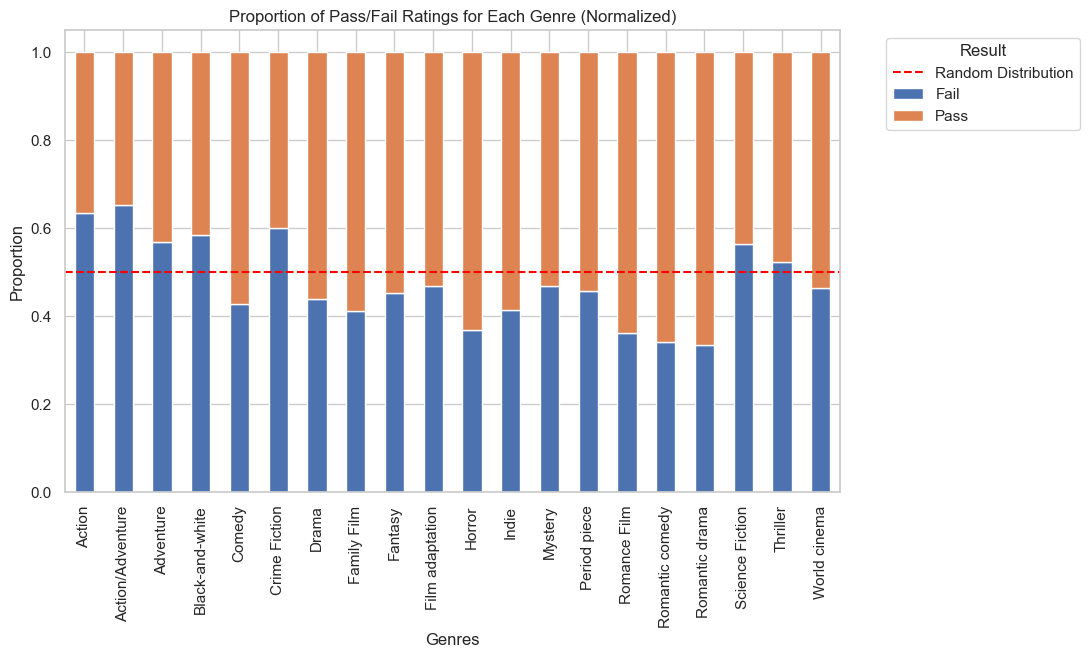

In [179]:
top20_merged['result'] = top20_merged['rating'].apply(lambda x: 'Fail' if x in [0, 1, 2] else 'Pass')

# Group by 'genres' and 'result', and calculate proportions
genre_result_proportions = top20_merged.groupby(['genres', 'result']).size() / top20_merged.groupby('genres').size()

# Reset the index to make it a DataFrame
genre_result_proportions = genre_result_proportions.reset_index(name='proportion')

# Pivot the DataFrame to have 'result' as columns
genre_result_proportions_pivot = genre_result_proportions.pivot(index='genres', columns='result', values='proportion')

# Plotting
ax = genre_result_proportions_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.axhline(y=0.5, color='red', linestyle='--', label='Random Distribution')
ax.set_ylabel('Proportion')
ax.set_xlabel('Genres')
ax.set_title('Proportion of Pass/Fail Ratings for Each Genre (Normalized)')
plt.legend(title='Result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [180]:
top20_merged['result'] = top20_merged['rating'].apply(lambda x: 'Fail' if x in [0, 1, 2] else 'Pass')

# Calculate the proportion of "Pass" for each genre
genre_pass_proportions = top20_merged[top20_merged['result'] == 'Pass'].groupby('genres').size() / top20_merged.groupby('genres').size()

# Collect the proportions into a list
proportions_list = genre_pass_proportions.tolist()

# Perform one-sample t-test on the list of proportions
t_stat, p_value = ttest_1samp(proportions_list, 0.5)

# Display the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print('The series of proportions is significantly different from a distribution with mean 0.5.')
else:
    print('The series of proportions is not significantly different from a distribution with mean 0.5.')

T-statistic: 1.0809096923095207
P-value: 0.2932668637735363
The series of proportions is not significantly different from a distribution with mean 0.5.


/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/1502269555.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Specific cases

### a) Romantic movies


/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/2345953134.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



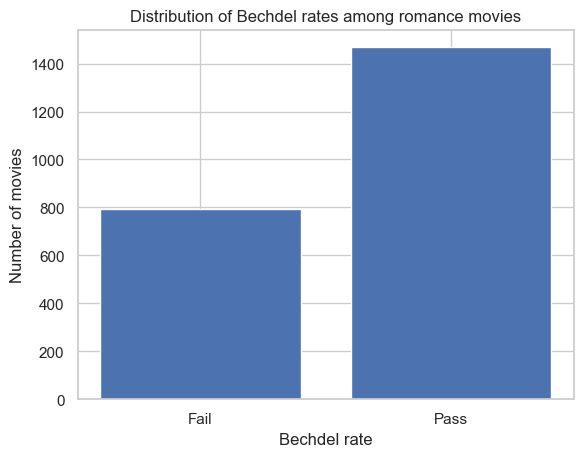

In [181]:
#Romance genres: 'Romance film', 'Romantic comedy', 'Romentic drama'
romance_genres = ['/m/02l7c8','/m/06cvj','/m/068d7h']
#Filter Merged with top 10
romance_films = merged_exploded[merged_exploded['genres'].isin(romance_genres)]
# Create a new column 'Pass/Fail' based on the 'rating'
romance_films['Pass/Fail'] = romance_films['rating'].apply(lambda x: 'Pass' if x == 3 else 'Fail')

# Group by 'Pass/Fail' and count the occurrences
yo = romance_films.groupby(['Pass/Fail']).size()

# Plot the bar chart
plt.bar(yo.index, yo.values)
plt.ylabel('Number of movies')
plt.xlabel('Bechdel rate')
plt.title('Distribution of Bechdel rates among romance movies')
plt.show()

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/1295302096.py:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




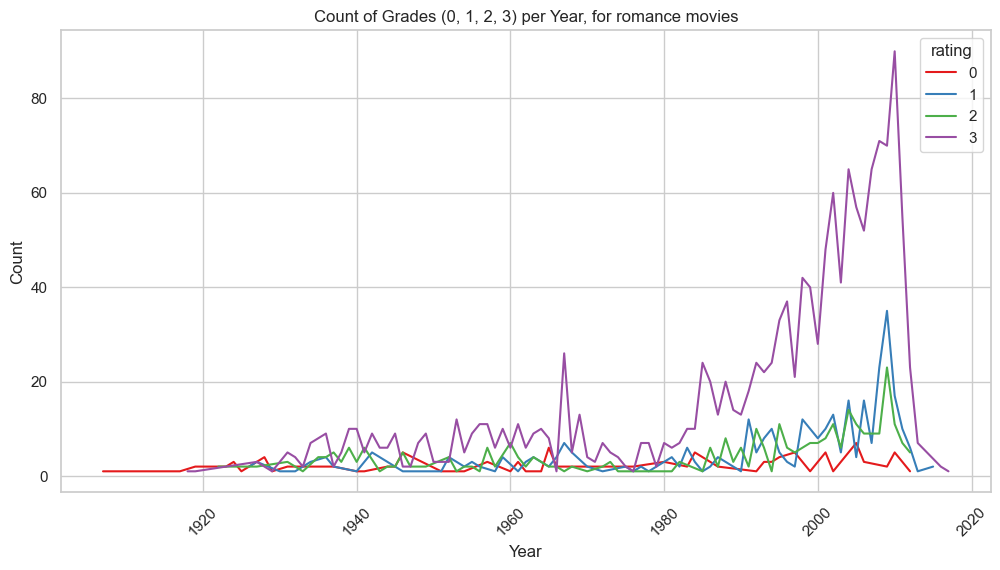

In [182]:
# Create a line plot with counts
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_x', y='rating', hue='rating', estimator='count', data=romance_films, ci=None,palette='Set1')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Count of Grades (0, 1, 2, 3) per Year, for romance movies')

# Display the plot
plt.show()

### b) Animation movies

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/136025773.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Distribution of Bechdel rates among animation movies')

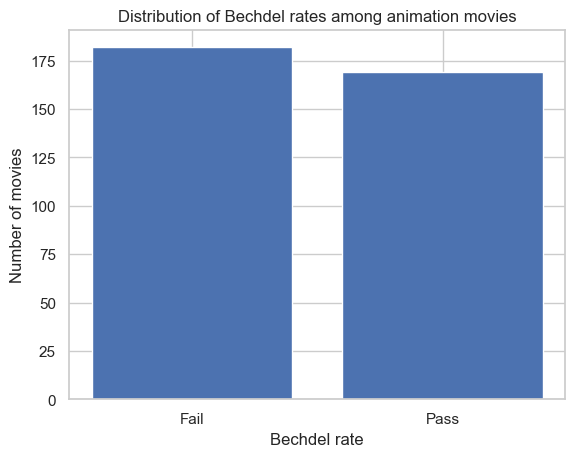

In [183]:
anim_films = merged_exploded[merged_exploded['genres'].isin(["/m/0hcr"])]

anim_films['Pass/Fail'] = anim_films['rating'].apply(lambda x: 'Pass' if x == 3 else 'Fail')
plt.bar(anim_films.groupby('Pass/Fail').count().index,anim_films.groupby('Pass/Fail').count()['id'])
plt.ylabel('Number of movies')
plt.xlabel('Bechdel rate')
plt.title('Distribution of Bechdel rates among animation movies')

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/864959262.py:12: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




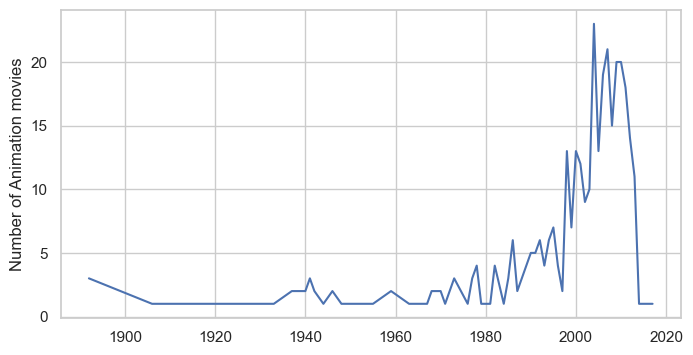

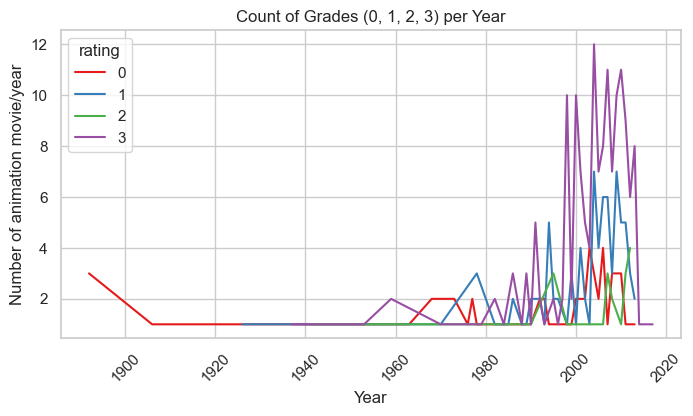

In [184]:
#We look at the evolution of rates of animation movies across years
#First we plot the total amount of animation movies per year
plt.figure(figsize=(8, 4))
plt.plot(anim_films.groupby('year_x').count().index, anim_films.groupby('year_x').count()['id'])
plt.ylabel('Number of Animation movies')

#Then we plot the grade evolution
sns.set(style="whitegrid")

# Create a line plot with counts
plt.figure(figsize=(8, 4))
sns.lineplot(x='year_x', y='rating', hue='rating', estimator='count', data=anim_films, ci=None,palette='Set1')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Number of animation movie/year')
plt.xticks(rotation=45)
plt.title('Count of Grades (0, 1, 2, 3) per Year')

# Display the plot
plt.show()

### c) Political drama

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/1641980030.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Distribution of Bechdel rates among Political movies')

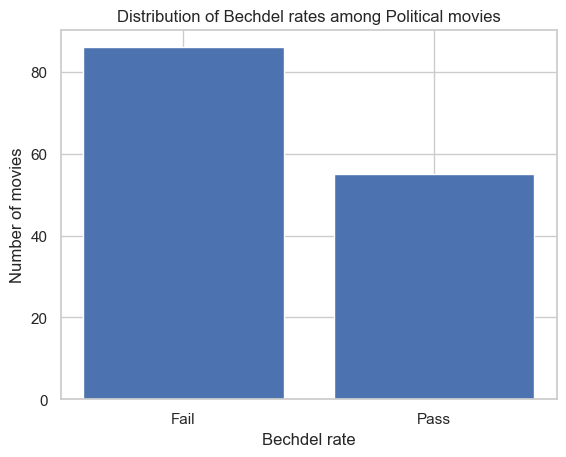

In [185]:
#Genre "Political drama" or "Political cinema"
politicfilms = merged_exploded[merged_exploded['genres'].isin(["/m/03mqtr","/m/0cshrf"])]
politicfilms['Pass/Fail'] = politicfilms['rating'].apply(lambda x: 'Pass' if x == 3 else 'Fail')
plt.bar(politicfilms.groupby('Pass/Fail').count().index,politicfilms.groupby('Pass/Fail').count()['id'])

plt.ylabel('Number of movies')
plt.xlabel('Bechdel rate')
plt.title('Distribution of Bechdel rates among Political movies')


In [186]:
politicfilms.groupby('Pass/Fail').count()['id']

Pass/Fail
Fail    86
Pass    55
Name: id, dtype: int64

### d) War film 

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/1601560488.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Distribution of Bechdel rates among War movies')

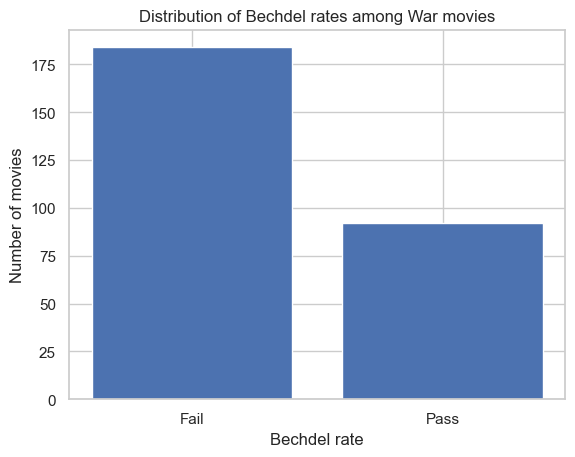

In [187]:
warfilms = merged_exploded[merged_exploded['genres'].isin(["/m/082gq"])]
warfilms['Pass/Fail'] = warfilms['rating'].apply(lambda x: 'Pass' if x == 3 else 'Fail')
plt.bar(warfilms.groupby('Pass/Fail').count().index,warfilms.groupby('Pass/Fail').count()['id'])

plt.ylabel('Number of movies')
plt.xlabel('Bechdel rate')
plt.title('Distribution of Bechdel rates among War movies')

### e) LGBT films

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/1973038774.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Distribution of Bechdel rates among LGBT movies')

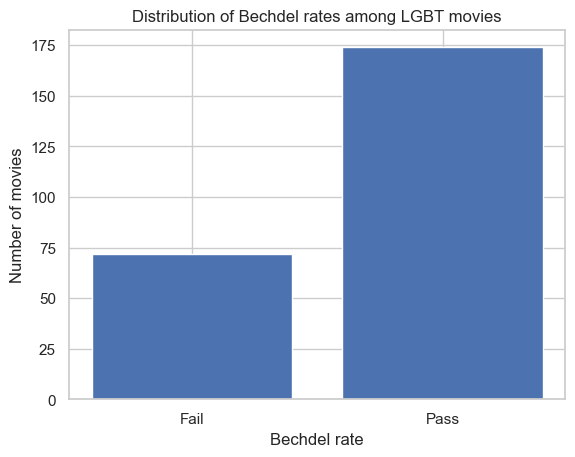

In [188]:
lgbtfilms = merged_exploded[merged_exploded['genres'].isin(["/m/0hn10"])]
lgbtfilms['Pass/Fail'] = lgbtfilms['rating'].apply(lambda x: 'Pass' if x == 3 else 'Fail')
plt.bar(lgbtfilms.groupby('Pass/Fail').count().index,lgbtfilms.groupby('Pass/Fail').count()['id'])

plt.ylabel('Number of movies')
plt.xlabel('Bechdel rate')
plt.title('Distribution of Bechdel rates among LGBT movies')


### d)Teen : Coming of age
Coming-of-age films focus on the psychological and moral growth or transition of a protagonist from youth to adulthood.

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/2738889516.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/2738889516.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Rating for Teen movies')

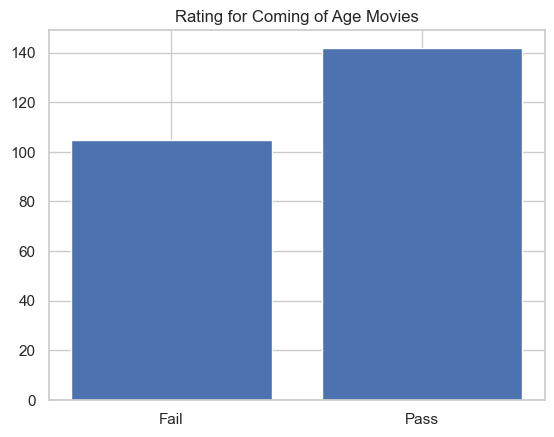

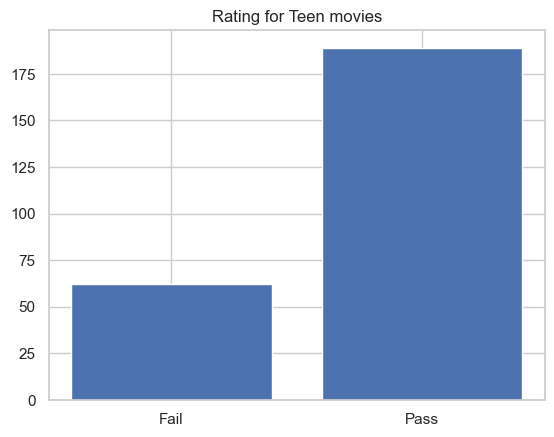

In [189]:
CoA_films = merged_exploded[merged_exploded['genres'].isin(["/m/01j1n2"])]
CoA_films['Pass/Fail'] = CoA_films['rating'].apply(lambda x: 'Pass' if x == 3 else 'Fail')
plt.figure()
plt.bar(CoA_films.groupby('Pass/Fail').count().index,CoA_films.groupby('Pass/Fail').count()['id'])
plt.title('Rating for Coming of Age Movies')

Teen_films = merged_exploded[merged_exploded['genres'].isin(["/m/02b5_l"])]
Teen_films['Pass/Fail'] = Teen_films['rating'].apply(lambda x: 'Pass' if x == 3 else 'Fail')
plt.figure()
plt.bar(Teen_films.groupby('Pass/Fail').count().index,Teen_films.groupby('Pass/Fail').count()['id'])
plt.title('Rating for Teen movies')


/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/128067136.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Number of movies')

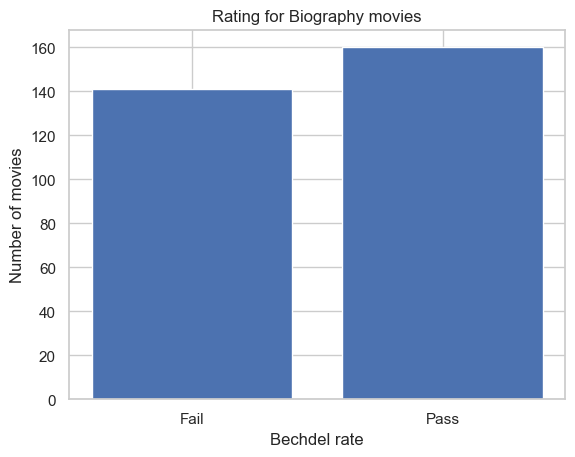

In [190]:
#Biographical films, biography
biography_films = merged_exploded[merged_exploded['genres'].isin(["/m/03bxz7","/m/017fp"])]
biography_films['Pass/Fail'] = biography_films['rating'].apply(lambda x: 'Pass' if x == 3 else 'Fail')
plt.figure()
plt.bar(biography_films.groupby('Pass/Fail').count().index,biography_films.groupby('Pass/Fail').count()['id'])

plt.title('Rating for Biography movies')
plt.xlabel('Bechdel rate')
plt.ylabel('Number of movies')

In [191]:
biography_films.groupby('Pass/Fail').count()['id']

Pass/Fail
Fail    141
Pass    160
Name: id, dtype: int64

## 3) Production company

In [192]:
#Investigate dataset of production companies
print(f"Proportion of NaNs in 'Production Company' column  (%): {round(100*(merged_df['Production Company'].isnull().sum()/len(merged_df)),2)}")

Proportion of NaNs in 'Production Company' column  (%): 27.82


In [193]:
#Top production companies --> check if studios appear with different names
top40_prod = merged_df.groupby('Production Company').count().sort_values(by='id',ascending=False).index[0:40]
print('The top 40 most present Production companies in the dataframe are:')
print(top40_prod)

#Walt Disney is present in two different names: 'The Walt Disney Company', 'Walt Disney Pictures'
merged_df['Production Company'] = merged_df['Production Company'].replace('The Walt Disney Company', 'Walt Disney Pictures')

#Same for StudioCanal and Canal+
merged_df['Production Company'] = merged_df['Production Company'].replace('Canal+', 'StudioCanal')

The top 40 most present Production companies in the dataframe are:
Index(['Warner Bros.', '20th Century Studios', 'Paramount Pictures',
       'Universal Pictures', 'Metro-Goldwyn-Mayer', 'Columbia Pictures',
       'New Line Cinema', 'Walt Disney Pictures', 'United Artists Corporation',
       'Touchstone Pictures', 'RKO Pictures', 'Lionsgate', 'DreamWorks',
       'The Walt Disney Company', 'Miramax', 'Amblin Entertainment',
       'StudioCanal', 'Toho', 'Relativity Media', 'Castle Rock Entertainment',
       'Regency Enterprises', 'Searchlight Pictures', 'Canal+',
       'Imagine Entertainment', 'BBC Film', 'Dimension Films',
       'TriStar Pictures', 'Revolution Studios', 'Village Roadshow Pictures',
       'PolyGram Filmed Entertainment', 'DreamWorks Animation',
       'Film4 Productions', 'Focus Features', 'Silver Pictures',
       'Summit Entertainment', 'Original Film', 'Gaumont Film Company',
       'Constantin Film', 'Spyglass Media Group', 'Orion Pictures'],
      dtype='ob

In [194]:
#Afficher le nombre de companies differentes dans le dataset
unique_prod = merged_df['Production Company'].unique()
print('the merged df contains',len(unique_prod),'different production companies')
print(len(merged_df.groupby('Production Company').count()[merged_df.groupby('Production Company').count()['id']==1]),'prods are in only 1 movie')

#Top 7 most present production companies : Top 7 have more than 100 movies
top7_prod = merged_df.groupby('Production Company').count().sort_values(by='id',ascending=False).index[0:7]
print(top7_prod)


the merged df contains 835 different production companies
450 prods are in only 1 movie
Index(['Warner Bros.', '20th Century Studios', 'Paramount Pictures',
       'Universal Pictures', 'Metro-Goldwyn-Mayer', 'Columbia Pictures',
       'Walt Disney Pictures'],
      dtype='object', name='Production Company')


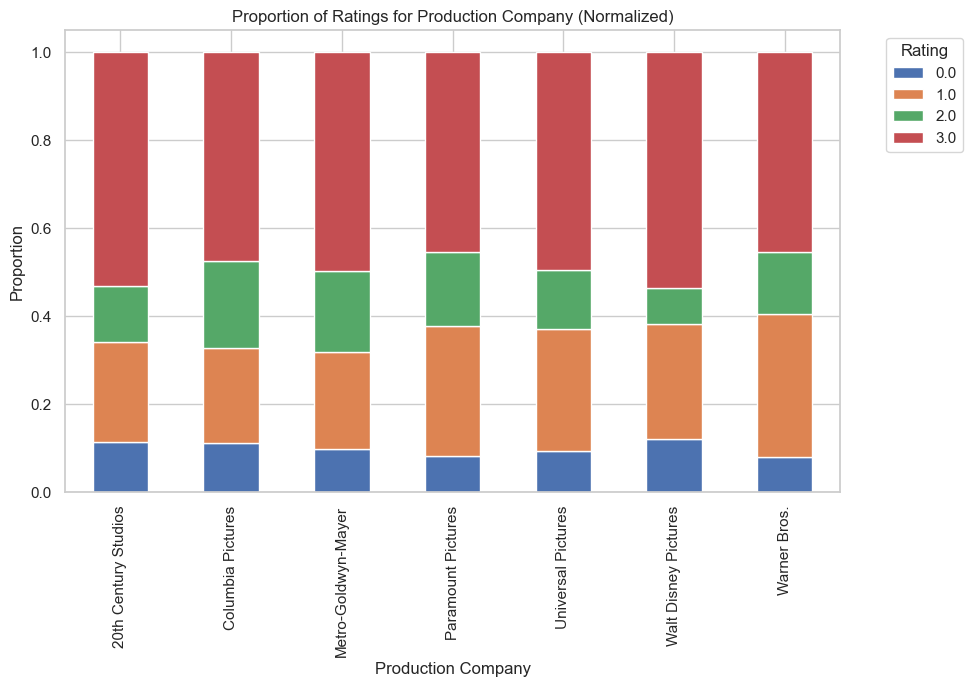

In [195]:
#Display rate distributions for the top 7
filtered_df7 = merged_df[merged_df['Production Company'].isin(top7_prod)]

# Group by 'genres' and 'rating', and calculate proportions
prod_rating_proportions = filtered_df7.groupby(['Production Company', 'rating']).size() / filtered_df7.groupby('Production Company').size()

# Reset the index to make it a DataFrame
prod_rating_proportions = prod_rating_proportions.reset_index(name='proportion')

# Pivot the DataFrame to have 'rating' as columns
prod_rating_proportions_pivot = prod_rating_proportions.pivot(index='Production Company', columns='rating', values='proportion')

# Plotting
ax = prod_rating_proportions_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Proportion')
ax.set_xlabel('Production Company')
ax.set_title('Proportion of Ratings for Production Company (Normalized)')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/3744948232.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



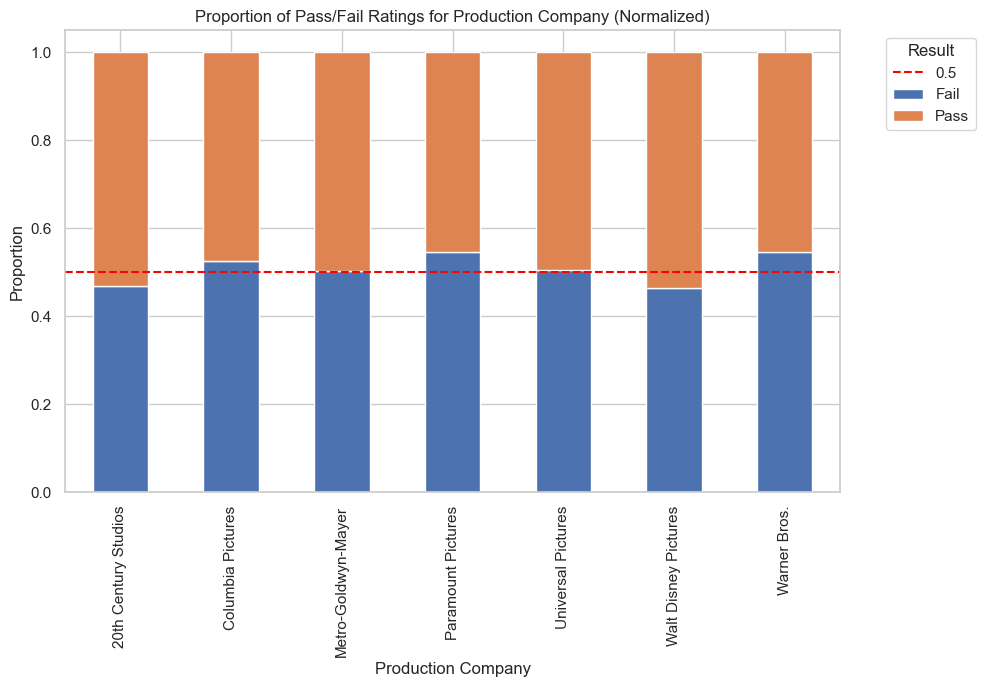

In [196]:
filtered_df7['result'] = filtered_df7['rating'].apply(lambda x: 'Fail' if x in [0, 1, 2] else 'Pass')

# Group by 'Production Company' and 'result', and calculate proportions
prod_result_proportions = filtered_df7.groupby(['Production Company', 'result']).size() / filtered_df7.groupby('Production Company').size()
prod_result_proportions = prod_result_proportions.reset_index(name='proportion')

# Pivot the DataFrame to have 'result' as columns
prod_result_proportions_pivot = prod_result_proportions.pivot(index='Production Company', columns='result', values='proportion')

# Plotting
ax = prod_result_proportions_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Proportion')
ax.set_xlabel('Production Company')
ax.set_title('Proportion of Pass/Fail Ratings for Production Company (Normalized)')
ax.axhline(y=0.5, color='red', linestyle='--', label='0.5')
plt.legend(title='Result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [197]:
prod_result_proportions_pivot

result,Fail,Pass
Production Company,,
20th Century Studios,0.468182,0.531818
Columbia Pictures,0.524691,0.475309
Metro-Goldwyn-Mayer,0.502890,0.497110
Paramount Pictures,0.545894,0.454106
Universal Pictures,0.505208,0.494792
Walt Disney Pictures,0.463415,0.536585
Warner Bros.,0.546667,0.453333


In [198]:
# Prepare the contingency table
contingency_table = prod_result_proportions_pivot[['Fail', 'Pass']].values

# Perform Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square value: {chi2}")
print(f"P-value: {p_value}")

Chi-square value: 0.02727427905108224
P-value: 0.999999581612967


A p-value of 0.3175 is greater than 0.05 and indicated that there is not enough evidence to reject the null hypothesis that the distributions of Fail and Pass proportions are the same between the production companies. We do not have enough evidence to conclude that Production Companies will impact the proportion of passing and failing movies, ie Production Companies are impacting the Bechdel rate. Production Company may not be a relevant feature.


### a) Specific case: Production "Focus Feature"

Text(0.5, 1.0, 'Bechdel rate distribution for movies of production company "Focus Feature"')

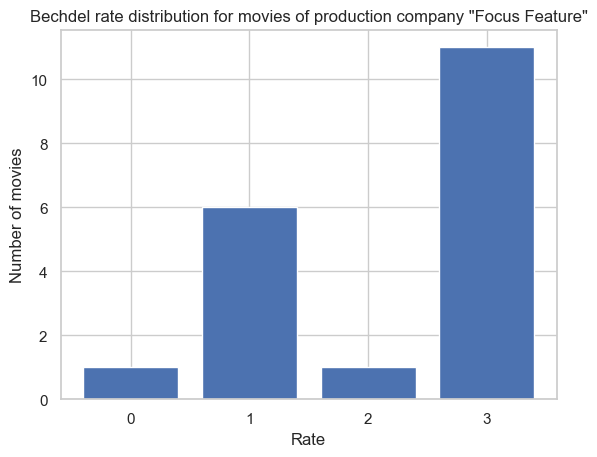

In [199]:
#these are known woke:  A24, Focus Features, and Participant Media.
#we have few movies from Focus Features in our dataset, let's check this
focus_feat = merged_df[merged_df['Production Company']=='Focus Features']
plt.bar(focus_feat.groupby('rating').count().index,focus_feat.groupby('rating').count()['id'])
plt.xticks([0,1,2,3])
plt.ylabel('Number of movies')
plt.xlabel('Rate')
plt.title('Bechdel rate distribution for movies of production company "Focus Feature"')

### b) Specific case: Disney

Text(0.5, 1.0, 'Bechdel rate distribution for movies of production company "Disney"')

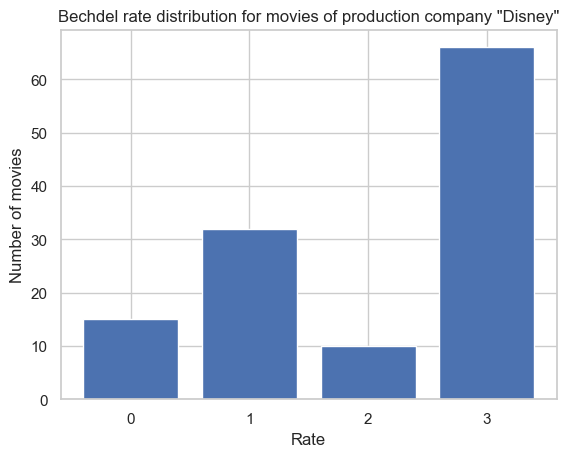

In [200]:
disney = merged_df[merged_df['Production Company']=='Walt Disney Pictures']
plt.bar(disney.groupby('rating').count().index,disney.groupby('rating').count()['id'])
plt.xticks([0,1,2,3])
plt.ylabel('Number of movies')
plt.xlabel('Rate')
plt.title('Bechdel rate distribution for movies of production company "Disney"')


### c) Specific case: Pixar

Text(0.5, 1.0, 'Bechdel rate distribution for movies of production company "Pixar"')

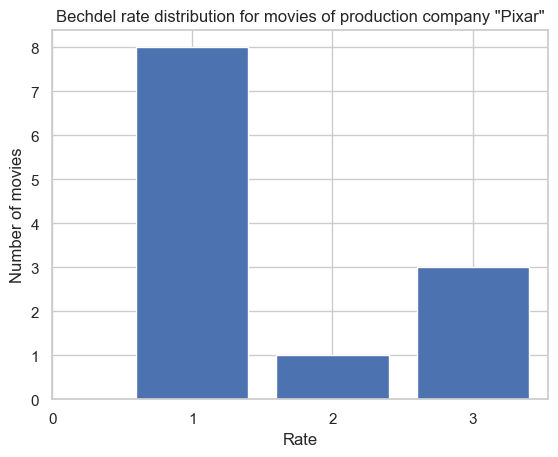

In [201]:
pixar = merged_df[merged_df['Production Company']=='Pixar']
plt.bar(pixar.groupby('rating').count().index,pixar.groupby('rating').count()['id'])
plt.xticks([0,1,2,3])
plt.ylabel('Number of movies')
plt.xlabel('Rate')
plt.title('Bechdel rate distribution for movies of production company "Pixar"')

### d) Correlation Genre/Production Company

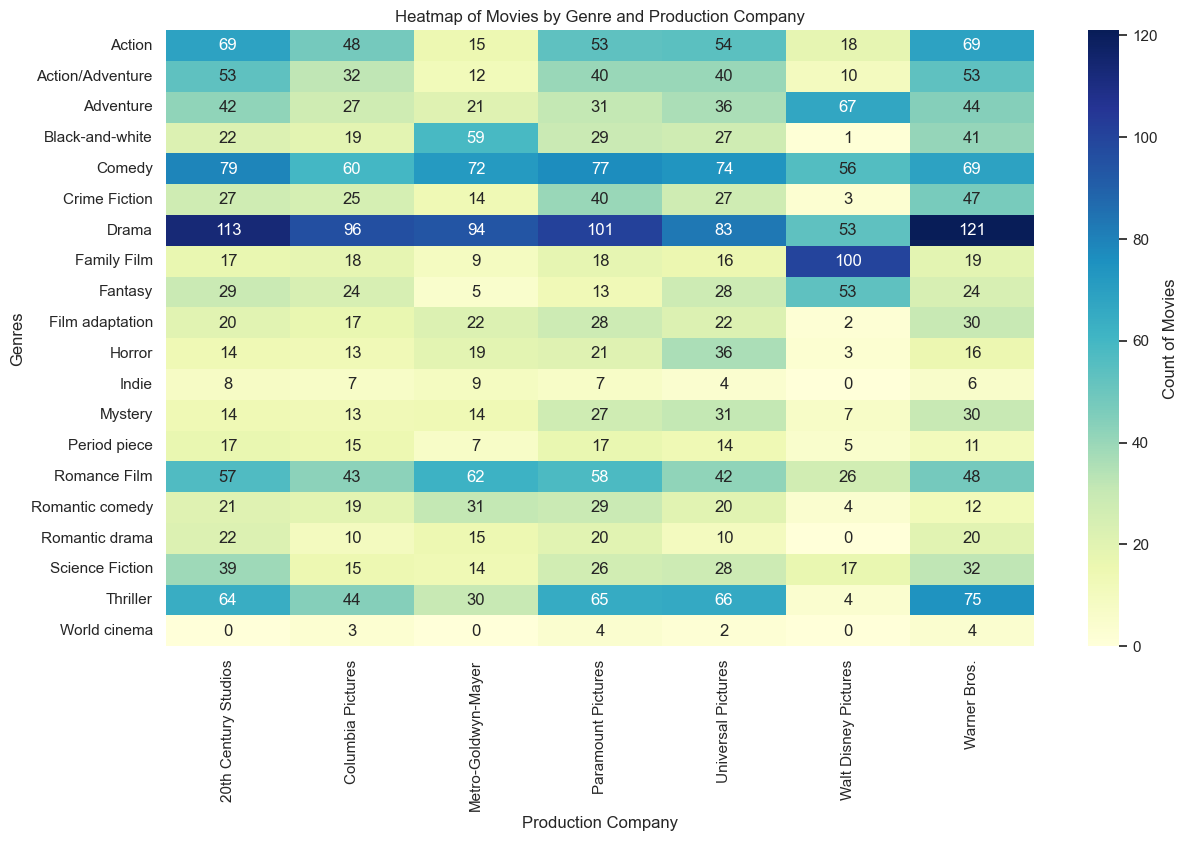

In [202]:
#Scatter plot genre/Production companies --> counfounding factors
filtered_df7_explode = filtered_df7.explode('genres')
filtered_df7_explode = filtered_df7_explode[filtered_df7_explode['genres'].isin(top20_genres)]

filtered_df7_explode['genres'] = filtered_df7_explode['genres'].replace(top20_dic) #Assign genre names


# Create a pivot table to get the count of movies for each genre and production company
heatmap_data = filtered_df7_explode.pivot_table(index='genres', columns='Production Company', values='id', aggfunc='count', fill_value=0)

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a heatmap using seaborn
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count of Movies'})

# Set labels and title
plt.xlabel('Production Company')
plt.ylabel('Genres')
plt.title('Heatmap of Movies by Genre and Production Company')

# Show the plot
plt.show()

### e) Correlation Production Company/Box Office Revenue

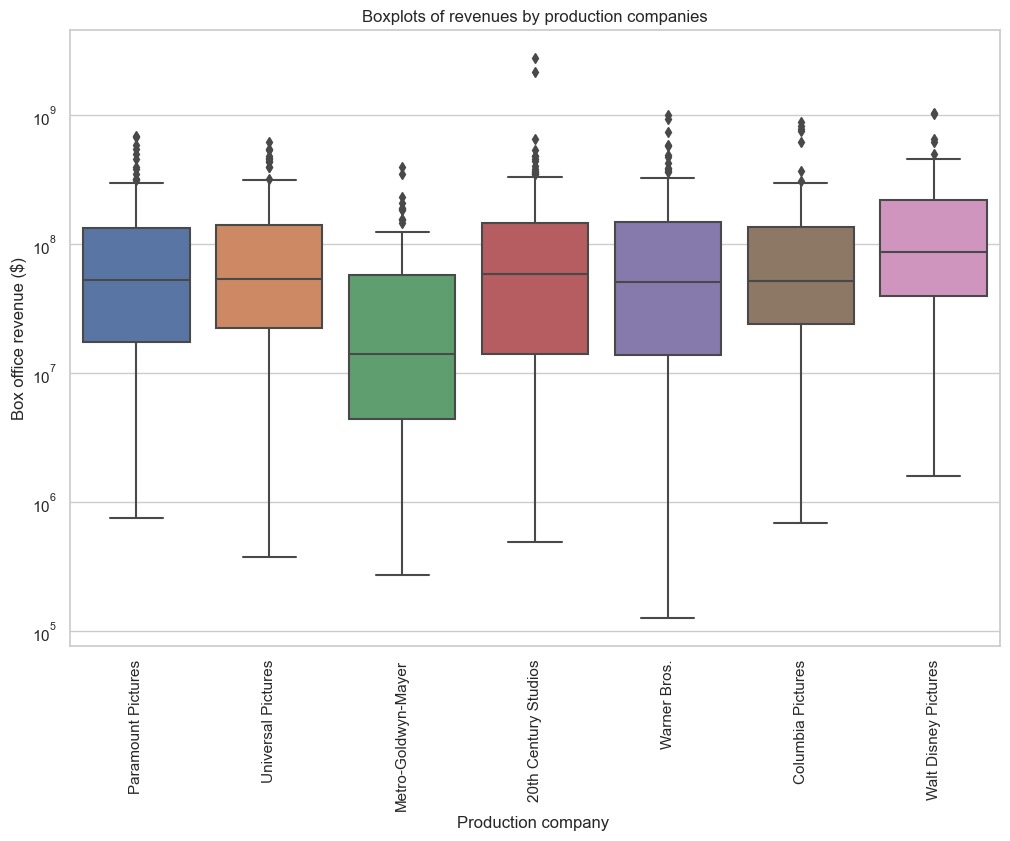

In [203]:
#Boxplot box office revenue/production company
#plot
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create boxplots using seaborn
sns.boxplot(x='Production Company', y='Movie box office revenue', data=filtered_df7)

# Set labels and title
plt.xlabel('Production company ')
plt.ylabel('Box office revenue ($)')
plt.title('Boxplots of revenues by production companies')
plt.yscale('log')
plt.xticks(rotation=90)

# Show the plot
plt.show()

#We have few movies that broke records: Titanic, Avatar, Pirate of the Carabeen!

In [204]:
def categorize_pass_fail(score):
    return 'pass' if score >= 3 else 'fail'

# Apply the categorization function to create a new column 'pass_fail'
top20_merged['pass_fail'] = top20_merged['rating'].apply(categorize_pass_fail)

# Group by 'production_company' and 'pass_fail', and calculate proportions
pass_fail_proportions = top20_merged.groupby(['Production Company', 'pass_fail']).size() / top20_merged.groupby('Production Company').size()

# Reset the index to make it a DataFrame
pass_fail_proportions = pass_fail_proportions.reset_index(name='proportion')

# Create a stacked bar plot using Plotly
fig = px.bar(pass_fail_proportions, 
             x='Production Company', 
             y='proportion', 
             color='pass_fail',  # This will split each bar by 'Pass' and 'Fail'
             labels={'proportion': 'Proportion'},
             title='Proportion of Pass and Fail for Each Production Company (Normalized)',
             height=600,
             color_discrete_map={'pass': '#FFD700', 'fail': '#B19CD9'})

# Update x and y axis titles
fig.update_xaxes(title='Production Companies', tickangle=45)
fig.update_yaxes(title='Proportion')

# Show the plot
fig.show(renderer="iframe")

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/1156330201.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [205]:
# Step 1: Calculate the pass proportions for each movie
filtered_df7['pass'] = filtered_df7['rating'].apply(lambda x: 1 if x >= 3 else 0)

# Step 2: Aggregate by Production Company and Year
pass_proportions = filtered_df7.groupby(['Production Company', 'year_x'])['pass'].mean().reset_index(name='Pass Proportion')

# Step 3: Calculate statistics for box plot (mean, quartiles, etc.)
summary_stats = pass_proportions.groupby('Production Company')['Pass Proportion'].describe().reset_index()

# Create a box plot using Plotly
fig = px.box(pass_proportions, 
             x='Production Company',  # Production Company as x-axis
             y='Pass Proportion', 
             labels={'Pass Proportion': 'Proportion of Pass'},
             title='Distribution of Pass Proportions for Each Production Company Over Time',
             height=600)

# Update x and y axis titles
fig.update_xaxes(title='Production Companies', tickangle=45)  # Rotate labels for better visibility
fig.update_yaxes(title='Proportion of Pass')

# Show the figure
fig.show(renderer="iframe")


/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/3071852509.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [206]:
# List of unique production companies
companies = pass_proportions['Production Company'].unique()

# Dictionary to store separate DataFrames for each company
company_dfs = {}

# Iterate over each company and create a separate DataFrame
for company in companies:
    subset_df = pass_proportions[pass_proportions['Production Company'] == company]
    company_dfs[company] = subset_df

# Now, company_dfs dictionary contains separate DataFrames for each company.
# For example, to access the DataFrame for '20th Century Studios':
print(company_dfs['20th Century Studios'])

      Production Company  year_x  Pass Proportion
0   20th Century Studios  1927.0              0.0
1   20th Century Studios  1931.0              0.0
2   20th Century Studios  1937.0              1.0
3   20th Century Studios  1939.0              0.0
4   20th Century Studios  1940.0              0.0
..                   ...     ...              ...
72  20th Century Studios  2010.0              0.4
73  20th Century Studios  2011.0              0.5
74  20th Century Studios  2012.0              0.6
75  20th Century Studios  2013.0              0.6
76  20th Century Studios  2022.0              0.0

[77 rows x 3 columns]


In [207]:
# List of unique production companies
companies = pass_proportions['Production Company'].unique()

# Create combinations of companies for comparison
company_pairs = combinations(companies, 2)

# Dictionary to store p-values for variance comparison between company pairs
p_values = {}

# Iterate over each pair of companies and perform Levene's test
for company1, company2 in company_pairs:
    subset_df1 = pass_proportions[pass_proportions['Production Company'] == company1]['Pass Proportion']
    subset_df2 = pass_proportions[pass_proportions['Production Company'] == company2]['Pass Proportion']
    
    # Convert the subsets to lists for the test
    subset_data1 = subset_df1.tolist()
    subset_data2 = subset_df2.tolist()
    
    # Ensure both subsets have enough data for the test
    if len(subset_data1) >= 2 and len(subset_data2) >= 2:
        # Apply Levene's test between the two companies
        stat, p_value = levene(subset_data1, subset_data2)
        
        # Store the p-value
        p_values[(company1, company2)] = p_value
    else:
        p_values[(company1, company2)] = "Not enough data for the test."

# Print the p-values
for (company1, company2), p_value in p_values.items():
    print(f"Levene's test p-value between {company1} and {company2}: {p_value}")


Levene's test p-value between 20th Century Studios and Columbia Pictures: 0.7475748617048179
Levene's test p-value between 20th Century Studios and Metro-Goldwyn-Mayer: 0.5732762125983077
Levene's test p-value between 20th Century Studios and Paramount Pictures: 0.6016192235028301
Levene's test p-value between 20th Century Studios and Universal Pictures: 0.5343685822246835
Levene's test p-value between 20th Century Studios and Walt Disney Pictures: 0.5567262752384687
Levene's test p-value between 20th Century Studios and Warner Bros.: 0.11163091424996353
Levene's test p-value between Columbia Pictures and Metro-Goldwyn-Mayer: 0.3932948234211394
Levene's test p-value between Columbia Pictures and Paramount Pictures: 0.402598153938994
Levene's test p-value between Columbia Pictures and Universal Pictures: 0.7852930347192225
Levene's test p-value between Columbia Pictures and Walt Disney Pictures: 0.7787319278428462
Levene's test p-value between Columbia Pictures and Warner Bros.: 0.05968

In [208]:
stats.spearmanr(pass_fail.index, percentage_year)

SignificanceResult(statistic=0.34108911560345156, pvalue=0.000550479598119025)

In [209]:
# Create a contingency table
contingency_table = pd.crosstab(filtered_df7['Production Company'], filtered_df7['pass'])

# Perform the chi-squared test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-Squared Value: {chi2}")
print(f"P-value: {p_value}")

# Interpret the p-value
if p_value < 0.05:
    print("There is a significant association between 'Production Company' and 'pass'.")
else:
    print("There is no significant association between 'Production Company' and 'pass'.")

Chi-Squared Value: 5.075279121084383
P-value: 0.5341949511021542
There is no significant association between 'Production Company' and 'pass'.


## 4) Box Office Revenue

In [210]:
#Check the proportion of NaNs values in the column 'Movie box office revenue' in the merged dataframe
nan_sum = merged_df['Movie box office revenue'].isna().sum()
print("Proportion of NaN values in 'Movie box office revenue': {:.2%}".format(nan_sum/len(merged_df)))

Proportion of NaN values in 'Movie box office revenue': 43.63%


We have much less NaNs values than in the orginal CMU dataset! This means that it will be able to do analysis on the revenue of movies passing or not the Bechdel Test

In [211]:
#Create a copy without the Nans values of revenues
revenue_df = bech_pass.dropna(subset=['Movie box office revenue']).copy()

In [212]:
# Plot the histogram
fig = px.histogram(revenue_df, x='Movie box office revenue', nbins=30,
                   labels={'Movie box office revenue': 'Movie Box Office Revenue', 'count': 'Frequency'},
                   title='Histogram of Movie Box Office Revenue of Films Passing Bechdel')

# Show the plot
fig.show(renderer="iframe")

In [213]:
#Drop Na values of the bechdel fail dataframe
revenue_fail_df = bech_fail.dropna(subset=['Movie box office revenue']).copy()
bins = np.linspace(revenue_fail_df['Movie box office revenue'].min(), revenue_fail_df['Movie box office revenue'].max(), 30)

# Plot the histogram
fig = px.histogram(revenue_fail_df, x='Movie box office revenue', nbins=30,
                   labels={'Movie box office revenue': 'Movie Box Office Revenue', 'count': 'Frequency'},
                   title='Histogram of Movie Box Office Revenue')

# Show the plot
fig.show(renderer="iframe")

In [214]:
# Define bins
bins = np.linspace(min(min(revenue_fail_df['Movie box office revenue']), min(revenue_df['Movie box office revenue'])),
                   max(max(revenue_fail_df['Movie box office revenue']), max(revenue_df['Movie box office revenue'])),
                   50)

# Calculate the percentage of films that pass for each bin
total_films_per_bin = np.histogram(revenue_fail_df['Movie box office revenue'], bins=bins)[0] + np.histogram(revenue_df['Movie box office revenue'], bins=bins)[0]
pass_percentage = np.histogram(revenue_df['Movie box office revenue'], bins=bins)[0] / total_films_per_bin

# Create a line plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=bins[:-1], y=pass_percentage, mode='lines+markers', name='Pass Percentage', line=dict(color='red')))

# Update layout
fig.update_xaxes(title='Movie Box Office Revenue')
fig.update_yaxes(title='Pass Percentage')
fig.update_layout(title='Pass Percentage vs Movie Box Office Revenue',
                  legend=dict(x=0, y=1, traceorder='normal', orientation='h'))

# Show the plot
fig.show(renderer="iframe")

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/4100716999.py:8: RuntimeWarning:

invalid value encountered in divide



In [215]:
valid_bins = bins[:-1][total_films_per_bin >= 10]

mask = revenue_df['Movie box office revenue'].apply(lambda x: np.searchsorted(valid_bins, x, side='right') % len(valid_bins) != 0)
mask1 = revenue_fail_df['Movie box office revenue'].apply(lambda x: np.searchsorted(valid_bins, x, side='right') % len(valid_bins) != 0)

# Use the mask to filter movies from both dataframes
revenue_df_filtered = revenue_df[mask]
revenue_fail_df_filtered = revenue_fail_df[mask1]

# Calculate pass percentage for each valid bin
pass_counts = np.histogram(revenue_df_filtered['Movie box office revenue'], bins=valid_bins)[0]
total_films_per_bin_1d = total_films_per_bin[total_films_per_bin >= 10][:len(pass_counts)].ravel()

# Avoid division by zero
pass_percentage = np.divide(pass_counts, total_films_per_bin_1d, out=np.zeros_like(pass_counts, dtype=float), where=total_films_per_bin_1d != 0)

# Create a line plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=valid_bins[:-1], y=pass_percentage, mode='lines+markers', name='Pass Percentage', line=dict(color='red')))

# Update layout
fig.update_xaxes(title='Movie Box Office Revenue')
fig.update_yaxes(title='Pass Percentage')
fig.update_layout(title='Pass Percentage vs Movie Box Office Revenue',
                  legend=dict(x=0, y=1, traceorder='normal', orientation='h'))

# Show the plot
fig.show(renderer="iframe")

In [216]:
pass_counts = np.histogram(revenue_df_filtered['Movie box office revenue'], bins=valid_bins)[0]
total_films_per_bin_1d = total_films_per_bin[total_films_per_bin >= 10][:len(pass_counts)].ravel()
pass_percentage = np.divide(pass_counts, total_films_per_bin_1d, 
                            out=np.zeros_like(pass_counts, dtype=float), where=total_films_per_bin_1d != 0)
standard_error = np.sqrt(pass_percentage * (1 - pass_percentage) / total_films_per_bin_1d)

# Define the z-value for 95% confidence interval (1.96 for 95% confidence)
z_value = 1.96
margin_of_error = z_value * standard_error
lower_bound = pass_percentage - margin_of_error
upper_bound = pass_percentage + margin_of_error

# Create the plot with confidence intervals
fig = go.Figure()

# Add pass percentage line and confidence intervals
fig.add_trace(go.Scatter(x=valid_bins[:-1], y=pass_percentage, mode='lines+markers', name='Pass Percentage', line=dict(color='red')))
fig.add_trace(go.Scatter(x=valid_bins[:-1], y=lower_bound, mode='lines', name='Lower Bound', line=dict(color='blue', dash='dash')))
fig.add_trace(go.Scatter(x=valid_bins[:-1], y=upper_bound, mode='lines', name='Upper Bound', line=dict(color='blue', dash='dash')))

# Update layout
fig.update_xaxes(title='Movie Box Office Revenue')
fig.update_yaxes(title='Pass Percentage')
fig.update_layout(title='Pass Percentage vs Movie Box Office Revenue with 95% CI',
                  legend=dict(x=0, y=1, traceorder='normal', orientation='h'))

# Show the plot
fig.show(renderer="iframe")

In [217]:
# Calculate pass counts for each bin
pass_counts = np.histogram(revenue_df_filtered['Movie box office revenue'], bins=valid_bins)[0]
total_films_per_bin_1d = total_films_per_bin[total_films_per_bin >= 10][:len(pass_counts)].ravel()

# Compute the weight for each bin
weights = total_films_per_bin_1d / np.sum(total_films_per_bin_1d)

# Compute the weighted pass percentage for each bin
weighted_pass_percentage = (pass_counts / total_films_per_bin_1d) * weights

# Calculate confidence intervals (using standard error of the mean)
z_value = 1.96  # For 95% confidence interval
std_dev = np.sqrt(weighted_pass_percentage * (1 - weighted_pass_percentage) / total_films_per_bin_1d)
sem = std_dev / np.sqrt(total_films_per_bin_1d)
ci = z_value * sem

# Create the plot with weighted pass percentages and CIs
fig = go.Figure()

# Add upper and lower bounds for CIs with lightblue shade FIRST
fig.add_trace(go.Scatter(x=valid_bins[:-1], y=weighted_pass_percentage + ci, mode='lines', line=dict(color='lightblue'), showlegend=False))
fig.add_trace(go.Scatter(x=valid_bins[:-1], y=weighted_pass_percentage - ci, mode='lines', fill='tonexty', fillcolor='lightblue', line=dict(color='lightblue'), name='95% Confidence Interval'))

# Add weighted pass percentage line with red color SECOND to overlay on top of the confidence interval
fig.add_trace(go.Scatter(x=valid_bins[:-1], y=weighted_pass_percentage, mode='lines', name='Weighted Pass Percentage', line=dict(color='red')))

# Update layout
fig.update_xaxes(title='Movie Box Office Revenue')
fig.update_yaxes(title='Weighted Pass Percentage')
fig.update_layout(title='Weighted Pass Percentage with 95% Confidence Intervals vs Movie Box Office Revenue')

# Show the plot
fig.show(renderer="iframe")

#### Include Inflation

In [218]:
CPIdf = pd.read_csv('./data/CPI.csv')

# Display the first few rows of the DataFrame
print(CPIdf.head())

# Ensure usa_coeffs is initialized as a DataFrame
usa_coeffs = pd.DataFrame(columns=['Year', 'Coefficient'])

for TIME in range(1955, 2023):  # Adjusted to include 2022
    # Fetch the Value for 2022
    value_2022 = CPIdf.loc[CPIdf['TIME'] == 2022, 'Value'].values[0]
    
    # Fetch the Value for the current year in the loop
    value_current_year = CPIdf.loc[CPIdf['TIME'] == TIME, 'Value'].values[0]
    
    # Calculate the coefficient for each year relative to 2022
    coeff_value = value_2022 / value_current_year
    
    # Create a temporary DataFrame for the current year and its coefficient
    temp_df = pd.DataFrame({'Year': [TIME], 'Coefficient': [coeff_value]})
    
    # Concatenate the temporary DataFrame with usa_coeffs
    usa_coeffs = pd.concat([usa_coeffs, temp_df], ignore_index=True)

# Drop the '2022' row as it's the reference for the coefficients
usa_coeffs = usa_coeffs[usa_coeffs['Year'] != 2022]

# Check the usa_coeffs DataFrame
print(usa_coeffs)


  LOCATION        Country   SUBJECT                 Subject MEASURE Measure  \
0      USA  United States  CPALTT01  CPI: 01-12 - All items    IXOB   Index   
1      USA  United States  CPALTT01  CPI: 01-12 - All items    IXOB   Index   
2      USA  United States  CPALTT01  CPI: 01-12 - All items    IXOB   Index   
3      USA  United States  CPALTT01  CPI: 01-12 - All items    IXOB   Index   
4      USA  United States  CPALTT01  CPI: 01-12 - All items    IXOB   Index   

  FREQUENCY Frequency  TIME  Time Unit Code   Unit  PowerCode Code PowerCode  \
0         A    Annual  1955  1955       IDX  Index               0     Units   
1         A    Annual  1956  1956       IDX  Index               0     Units   
2         A    Annual  1957  1957       IDX  Index               0     Units   
3         A    Annual  1958  1958       IDX  Index               0     Units   
4         A    Annual  1959  1959       IDX  Index               0     Units   

  Reference Period Code Reference Period    

In [219]:
merged_rev_pass_df = revenue_df.merge(usa_coeffs, left_on='year_x', right_on='Year', how='left')
merged_rev_pass_df = merged_rev_pass_df.dropna(subset=['Coefficient'])
merged_rev_pass_df['Adjusted_Revenue'] = merged_rev_pass_df['Movie box office revenue'] * merged_rev_pass_df['Coefficient']


In [220]:
revenue_fail_df

merged_rev_fail_df = revenue_fail_df.merge(usa_coeffs, left_on='year_x', right_on='Year', how='left')
merged_rev_fail_df = merged_rev_pass_df.dropna(subset=['Coefficient'])
merged_rev_fail_df['Adjusted_Revenue'] = merged_rev_fail_df['Movie box office revenue'] * merged_rev_fail_df['Coefficient']


In [221]:
bins = np.linspace(min(min(merged_rev_fail_df['Adjusted_Revenue']), min(merged_rev_pass_df['Adjusted_Revenue'])),
                   max(max(merged_rev_fail_df['Adjusted_Revenue']), max(merged_rev_pass_df['Adjusted_Revenue'])),
                   50)

# Calculate the percentage of films that pass for each bin
total_films_per_bin_infl = np.histogram(merged_rev_pass_df['Adjusted_Revenue'], bins=bins)[0] + np.histogram(merged_rev_fail_df['Adjusted_Revenue'], bins=bins)[0]

In [222]:
#Histogram
fig = px.histogram(merged_rev_pass_df, 
                   x='Adjusted_Revenue', 
                   nbins=100,
                   labels={'Adjusted_Revenue': 'Adjusted Movie Box Office Revenue', 'count': 'Frequency'},
                   title='Histogram of Adjusted Movie Box Office Revenue of Films Passing Bechdel')

# Show the plot
fig.show(renderer="iframe")

In [223]:
# Calculate pass counts for each bin
pass_counts = np.histogram(merged_rev_pass_df['Adjusted_Revenue'], bins=valid_bins)[0]
total_films_per_bin_1d = total_films_per_bin_infl[total_films_per_bin_infl >= 10][:len(pass_counts)].ravel()

# Compute the weight for each bin
weights = total_films_per_bin_1d / np.sum(total_films_per_bin_1d)

# Compute the weighted pass percentage for each bin
weighted_pass_percentage = (pass_counts / total_films_per_bin_1d) * weights

# Calculate confidence intervals (using standard error of the mean)
z_value = 1.96  # For 95% confidence interval
std_dev = np.sqrt(weighted_pass_percentage * (1 - weighted_pass_percentage) / total_films_per_bin_1d)
sem = std_dev / np.sqrt(total_films_per_bin_1d)
ci = z_value * sem

# Create the plot with weighted pass percentages and CIs
fig = go.Figure()

# Add upper and lower bounds for CIs with lightblue shade FIRST
fig.add_trace(go.Scatter(x=valid_bins[:-1], y=weighted_pass_percentage + ci, mode='lines', line=dict(color='lightblue'), showlegend=False))
fig.add_trace(go.Scatter(x=valid_bins[:-1], y=weighted_pass_percentage - ci, mode='lines', fill='tonexty', fillcolor='lightblue', line=dict(color='lightblue'), name='95% Confidence Interval'))

# Add weighted pass percentage line with red color SECOND to overlay on top of the confidence interval
fig.add_trace(go.Scatter(x=valid_bins[:-1], y=weighted_pass_percentage, mode='lines', name='Weighted Pass Percentage', line=dict(color='red')))

# Update layout
fig.update_xaxes(title='Movie Box Office Revenue - Adjusted for Inflation')
fig.update_yaxes(title='Weighted Pass Percentage')
fig.update_layout(title='Weighted Pass Percentage with 95% Confidence Intervals vs Movie Box Office Revenue')

# Show the plot
fig.show(renderer="iframe")

In [224]:
#Spearman Test
stats.spearmanr(valid_bins[:-1], pass_percentage)

SignificanceResult(statistic=-0.6848484848484848, pvalue=0.02888279750673276)

In [225]:
stats.spearmanr(valid_bins[:-1], weighted_pass_percentage)

SignificanceResult(statistic=-0.9999999999999999, pvalue=6.646897422032013e-64)

From the data for the percentage of films that pass the Bechdel test as a function of revenue, considering only revenue baskets where we have data for 10 or more films, we note a significant correlation which is negative. This is corroborated by the spearman test. This basically means that films that pass the Bechdel test generally earn less than those that don't. 

#### END INFLATION

Text(0.5, 1.0, 'Movies with box office revenue >500000000.0$')

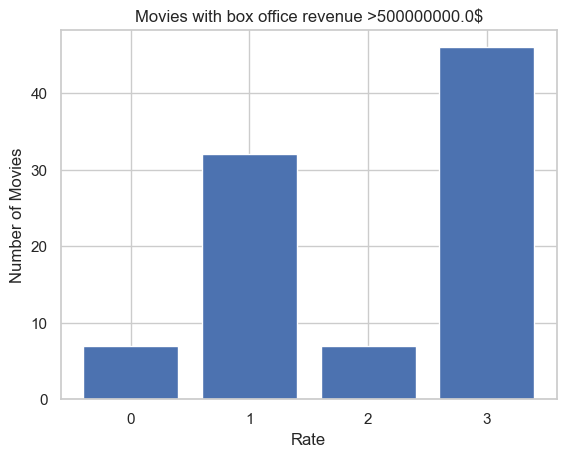

In [226]:
#Look at the movies with highest revenue in history:
treshold_revenue = 5e8
top_films_revenue = merged_df[merged_df['Movie box office revenue'] > treshold_revenue]

plt.bar(top_films_revenue.groupby('rating').count().index,top_films_revenue.groupby('rating').count()['id'])
plt.xticks([0,1,2,3])
plt.xlabel('Rate')
plt.ylabel('Number of Movies')
plt.title('Movies with box office revenue >'+ str(treshold_revenue) + '$')

In the movies having revenue greater than 0.5 Bilion $, there are some having very bad grades! Let's look which movies

In [227]:
print(merged_df[(merged_df['Movie box office revenue'] > treshold_revenue) & (merged_df['rating'] <2)][['title','rating']])

                                                  title  rating
1436                                          Star Wars     1.0
1555     Star Wars: Episode V - The Empire Strikes Back     0.0
2299                                            Aladdin     0.0
2469                                     Lion King, The     1.0
2480                                       Forrest Gump     1.0
2788                                       Men in Black     1.0
2903                                         Armageddon     1.0
3223                             Mission: Impossible II     0.0
3267                                     Monsters, Inc.     1.0
3279  Lord of the Rings: The Fellowship of the Ring,...     1.0
3451                                         Spider-Man     1.0
3583     Lord of the Rings: The Return of the King, The     1.0
3592                                       Finding Nemo     1.0
3765                                       Spider-Man 2     1.0
3802                                 Thi

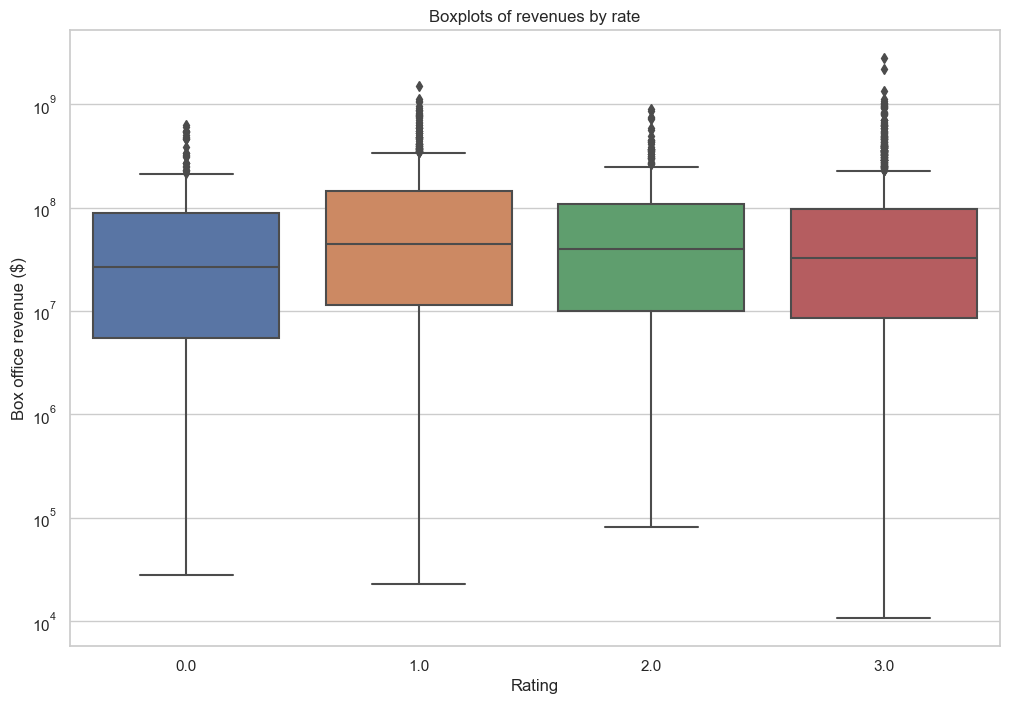

F-statistic: 5.449577485859059
P-value: 0.0009792787692153796
There is a significant difference in the distributions of Movie box office revenue across the rating categories.


In [228]:
## Box plots revenue/rating
plt.figure(figsize=(12, 8))

# Create boxplots using seaborn
sns.boxplot(x='rating', y='Movie box office revenue', data=merged_df)

# Set labels and title
plt.xlabel('Rating')
plt.ylabel('Box office revenue ($)')
plt.title('Boxplots of revenues by rate')
plt.yscale('log')


# Show the plot
plt.show()

#Test de Anova
#Statistical test on the 4 distributions
from scipy.stats import f_oneway

# Create separate 'Movie runtime' arrays for each rating category
rating_0 = merged_df.loc[merged_df['rating'] == 0, 'Movie box office revenue'].dropna()
rating_1 = merged_df.loc[merged_df['rating'] == 1, 'Movie box office revenue'].dropna()
rating_2 = merged_df.loc[merged_df['rating'] == 2, 'Movie box office revenue'].dropna()
rating_3 = merged_df.loc[merged_df['rating'] == 3, 'Movie box office revenue'].dropna()

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(rating_0, rating_1, rating_2, rating_3)

# Display the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print('There is a significant difference in the distributions of Movie box office revenue across the rating categories.')
else:
    print('There is no significant difference in the distributions of Movie box office revenue across the rating categories.')

In [229]:
from scipy.stats import f_oneway

# Create separate 'Movie runtime' arrays for each result category
fail_revenue = merged_df.loc[merged_df['rating'].isin([0, 1, 2]), 'Movie box office revenue'].dropna()
pass_revenue = merged_df.loc[merged_df['rating'] == 3, 'Movie box office revenue'].dropna()

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(fail_revenue, pass_revenue)

# Display the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print('There is a significant difference in the distributions of Movie box office revenue between "Fail" and "Pass" categories.')
else:
    print('There is no significant difference in the distributions of Movie box office revenue between "Fail" and "Pass" categories.')

F-statistic: 5.124353875640213
P-value: 0.023657472771464766
There is a significant difference in the distributions of Movie box office revenue between "Fail" and "Pass" categories.


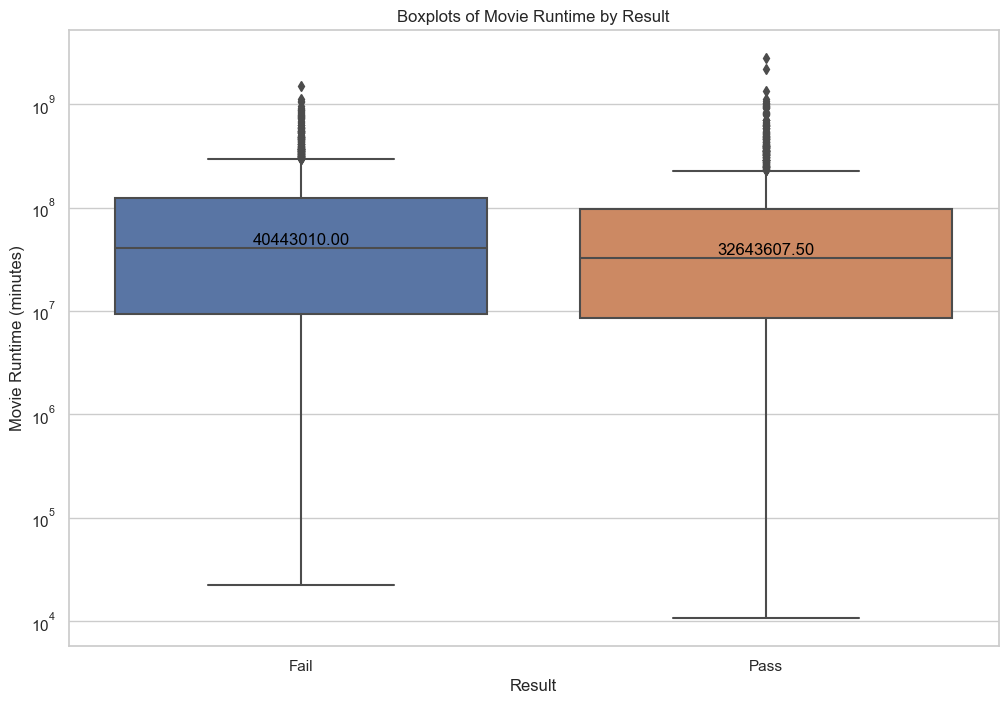

In [230]:
# Create a new column 'Result' based on the 'rating'
merged_df['Result'] = merged_df['rating'].map({0: 'Fail', 1: 'Fail', 2: 'Fail', 3: 'Pass'})

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create boxplots using seaborn
boxplot = sns.boxplot(x='Result', y='Movie box office revenue', data=merged_df)
# Display medians on the plot
medians = merged_df.groupby('Result')['Movie box office revenue'].median()
for i, median_value in enumerate(medians):
    boxplot.text(i, median_value, f'{median_value:.2f}', color='black', ha="center", va="bottom")

# Set labels and title
plt.xlabel('Result')
plt.ylabel('Movie Runtime (minutes)')
plt.title('Boxplots of Movie Runtime by Result')
plt.yscale('log')
# Show the plot
plt.show()

In [231]:
print(merged_df.groupby('Result')['Movie box office revenue'].mean())
print(merged_df.groupby('Result')['Movie box office revenue'].median())
print(merged_df.groupby('Result')['Movie box office revenue'].std())

Result
Fail    1.001890e+08
Pass    8.752803e+07
Name: Movie box office revenue, dtype: float64
Result
Fail    40443010.0
Pass    32643607.5
Name: Movie box office revenue, dtype: float64
Result
Fail    1.533139e+08
Pass    1.652057e+08
Name: Movie box office revenue, dtype: float64


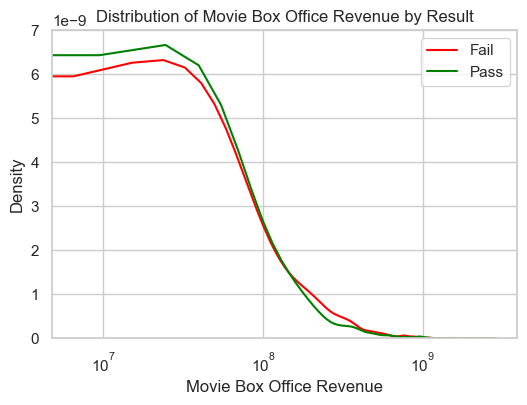

In [232]:
# Set up the matplotlib figure
plt.figure(figsize=(6, 4))

# Create KDE plots using seaborn
sns.kdeplot(data=merged_df[merged_df['Result'] == 'Fail'], x='Movie box office revenue', label='Fail',  color='red')
sns.kdeplot(data=merged_df[merged_df['Result'] == 'Pass'], x='Movie box office revenue', label='Pass',  color='green')

# Set labels and title
plt.xlabel('Movie Box Office Revenue')
plt.ylabel('Density')
plt.title('Distribution of Movie Box Office Revenue by Result')
plt.xscale('log')


# Show legend
plt.legend()

# Show the plot
plt.show()

## 5) Movie Runtime

Proportion of NaN values in 'Movie runtime': 3.83%
The proportion is small, it should not be a problem to investigate this feature


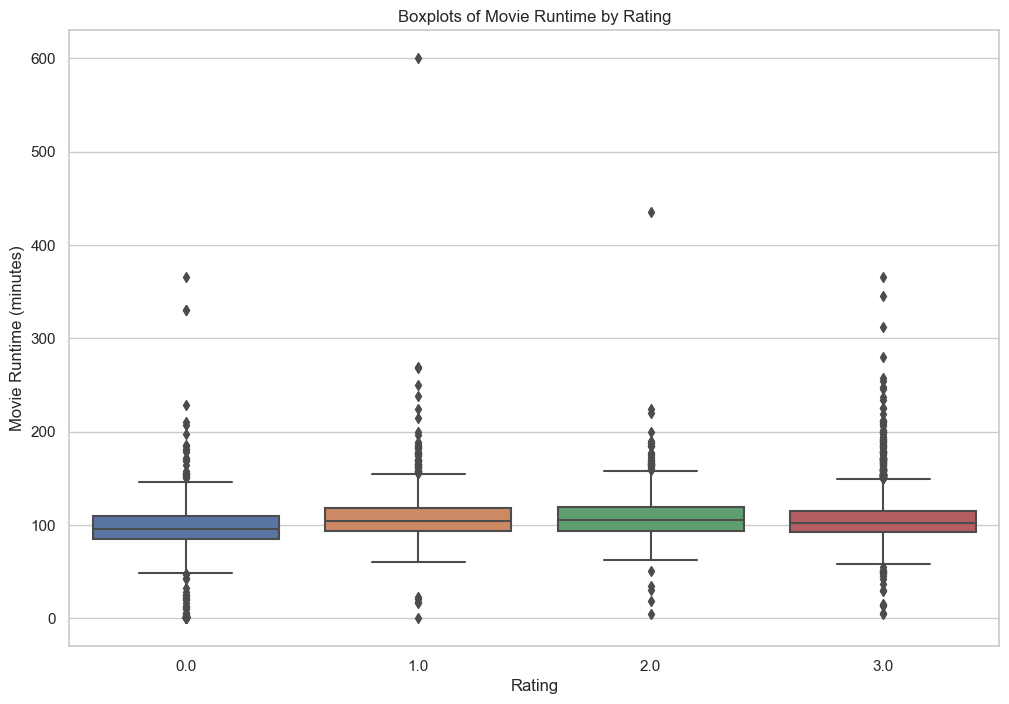

In [233]:
#Movie runtime ? The longer the movie, the higher is the chance of passing Bechdel ?
#Can we do this analysis (don't we have too many nans) ?
nan_sum = merged_df['Movie runtime'].isna().sum()
print("Proportion of NaN values in 'Movie runtime': {:.2%}".format(nan_sum/len(merged_df)))
if nan_sum/len(merged_df) <20:
    print('The proportion is small, it should not be a problem to investigate this feature')
else:
    print('more than 20% of the movies gave Nans in the movie runtime column!')

#plot
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create boxplots using seaborn
sns.boxplot(x='rating', y='Movie runtime', data=merged_df)

# Set labels and title
plt.xlabel('Rating')
plt.ylabel('Movie Runtime (minutes)')
plt.title('Boxplots of Movie Runtime by Rating')

# Show the plot
plt.show()

In [234]:
#Statistical test on the 4 distributions
from scipy.stats import f_oneway

# Create separate 'Movie runtime' arrays for each rating category
rating_0 = merged_df.loc[merged_df['rating'] == 0, 'Movie runtime'].dropna()
rating_1 = merged_df.loc[merged_df['rating'] == 1, 'Movie runtime'].dropna()
rating_2 = merged_df.loc[merged_df['rating'] == 2, 'Movie runtime'].dropna()
rating_3 = merged_df.loc[merged_df['rating'] == 3, 'Movie runtime'].dropna()

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(rating_0, rating_1, rating_2, rating_3)

# Display the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print('There is a significant difference in the distributions of movie runtime across the rating categories.')
else:
    print('There is no significant difference in the distributions of movie runtime across the rating categories.')

F-statistic: 31.745017331458453
P-value: 2.434291290412973e-20
There is a significant difference in the distributions of movie runtime across the rating categories.


In [235]:
#Curiosity : What are the very long movies only rated 0 or 1?
merged_df.sort_values(by='Movie runtime',ascending=False)

,Unnamed: 0.1,Unnamed: 0,imdbid,year_x,rating,id,title,WikiID,Wikipedia movie ID,Freebase movie ID,...,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),year_y,genres,Production Company,result,genres_dict,genres_names,Result
3386,3386.0,4119.0,185906.0,2001.0,1.0,7824.0,Band of Brothers,161779.0,161779.0,/m/015g28,...,"{""/m/064_8sq"": ""French Language"", ""/m/04306rv""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01f9r0"": ""Docudrama"", ""/m/082gq"": ""War fi...",NaN,"{'/m/01f9r0': 'Docudrama', '/m/082gq': 'War fi...",NaN,Fail,"{'/m/01f9r0': 'Docudrama', '/m/082gq': 'War fi...","[science, horror, horror, Creature Film, Actio...",Fail
2560,2560.0,3124.0,111341.0,1994.0,2.0,10672.0,Satantango,4340438.0,4340438.0,/m/0bntmhf,...,"{""/m/02ztjwg"": ""Hungarian language""}","{""/m/06mzp"": ""Switzerland"", ""/m/0h7x"": ""Austri...","{""/m/01jfsb"": ""Thriller"", ""/m/0hj3n0w"": ""Ensem...",NaN,"{'/m/01jfsb': 'Thriller', '/m/0hj3n0w': 'Ensem...",NaN,Fail,"{'/m/01jfsb': 'Thriller', '/m/0hj3n0w': 'Ensem...","[romantic, Romance Film, Marriage Drama, Drama]",Fail
2430,2430.0,2962.0,107007.0,1993.0,0.0,4917.0,Gettysburg,1236122.0,1236122.0,/m/04kzqz,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",NaN,"{'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...",Turner Entertainment,Fail,"{'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...","[Thriller, superhero, Children's/Family, super...",Fail
3616,3616.0,4389.0,346336.0,2003.0,3.0,1767.0,"Best of Youth, The",1789884.0,1789884.0,/m/05x427,...,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/03rjj"": ""Italy""}","{""/m/07s9rl0"": ""Drama""}",NaN,{'/m/07s9rl0': 'Drama'},Rai Fiction,Pass,{'/m/07s9rl0': 'Drama'},"[Drama, fantasy]",Pass
2476,2476.0,3020.0,108941.0,1994.0,3.0,537.0,"Stand, The",3473059.0,3473059.0,/m/09fc83,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""H...",1994.0,"{'/m/06n90': 'Science Fiction', '/m/03npn': 'H...",NaN,Pass,"{'/m/06n90': 'Science Fiction', '/m/03npn': 'H...","[science, horror, adventure, television, Dooms...",Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5806,5806.0,8223.0,810819.0,2015.0,3.0,6655.0,"Danish Girl, The",25329994.0,25329994.0,/m/09gcrsw,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",NaN,{'/m/07s9rl0': 'Drama'},Focus Features,Pass,{'/m/07s9rl0': 'Drama'},[Drama],Pass
5807,5807.0,8408.0,2975590.0,2016.0,2.0,6788.0,Batman v Superman: Dawn of Justice,2619910.0,2619910.0,/m/07s77y,...,{},{},{},NaN,{},RatPac-Dune Entertainment,Fail,{},[],Fail
5808,5808.0,8727.0,1293847.0,2017.0,3.0,7411.0,xXx: Return of Xander Cage,19326138.0,19326138.0,/m/083xgxs,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/02kdv5l"": ""Action""}",NaN,"{'/m/01jfsb': 'Thriller', '/m/02kdv5l': 'Action'}",Paramount Pictures,Pass,"{'/m/01jfsb': 'Thriller', '/m/02kdv5l': 'Action'}","[Thriller, action]",Pass
5815,5815.0,10030.0,1630029.0,2022.0,2.0,10676.0,Avatar: The Way Of Water,25813358.0,25813358.0,/m/0gmbk1g,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...",NaN,"{'/m/06n90': 'Science Fiction', '/m/02kdv5l': ...",20th Century Studios,Fail,"{'/m/06n90': 'Science Fiction', '/m/02kdv5l': ...","[science, action, fantasy, adventure]",Fail


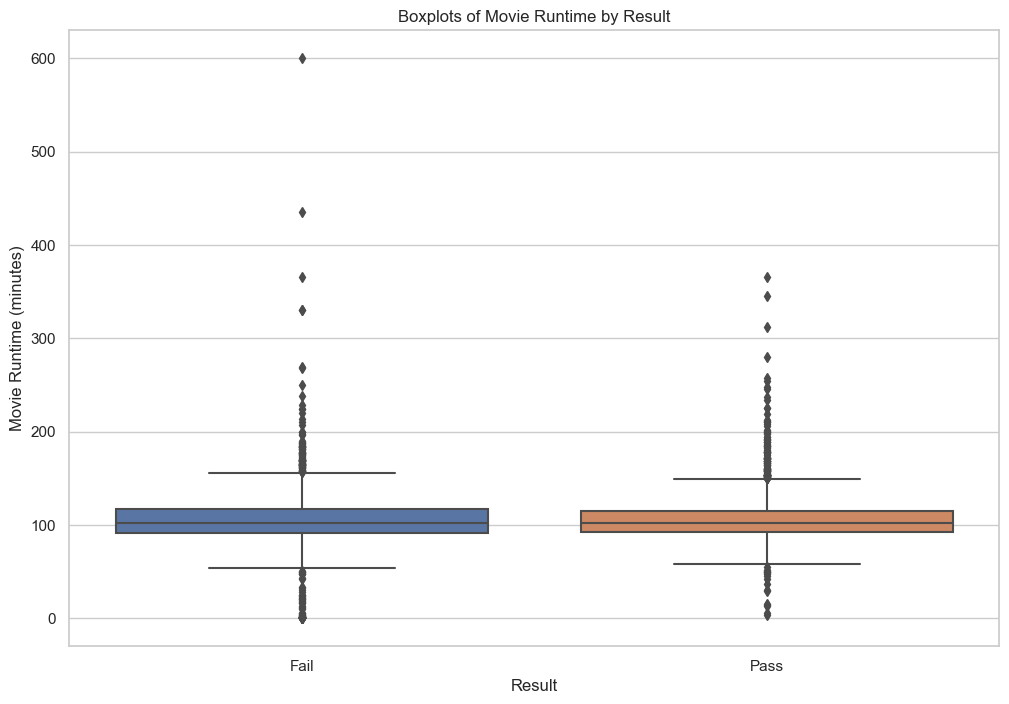

In [236]:
# Create a new column 'Result' based on the 'rating'
merged_df['Result'] = merged_df['rating'].map({0: 'Fail', 1: 'Fail', 2: 'Fail', 3: 'Pass'})

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create boxplots using seaborn
sns.boxplot(x='Result', y='Movie runtime', data=merged_df)

# Set labels and title
plt.xlabel('Result')
plt.ylabel('Movie Runtime (minutes)')
plt.title('Boxplots of Movie Runtime by Result')

# Show the plot
plt.show()

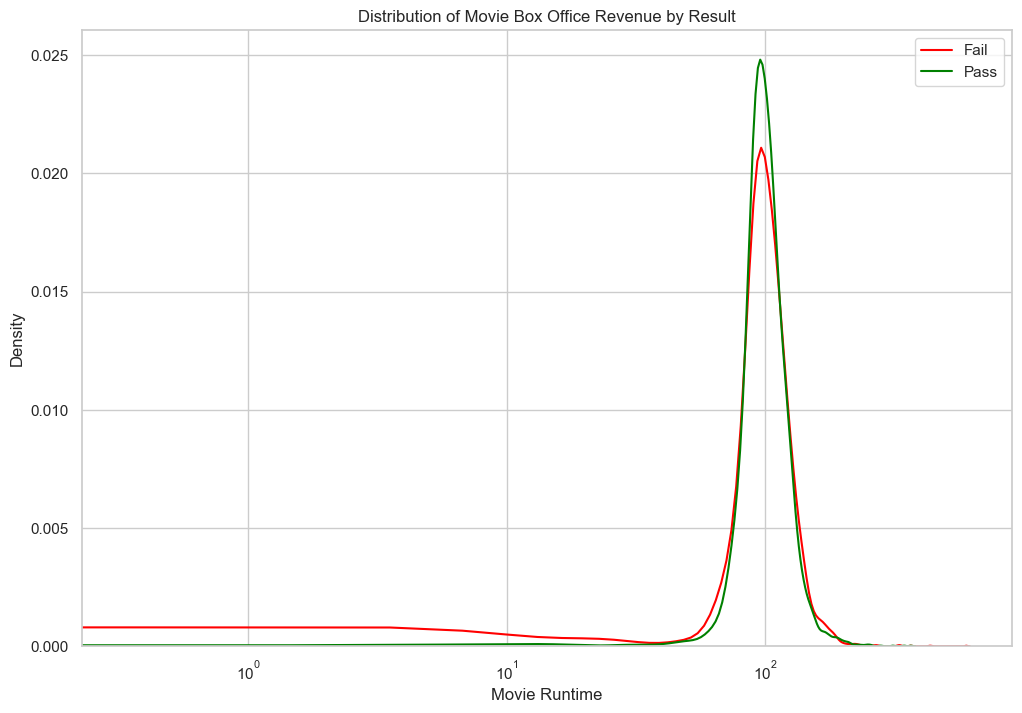

In [237]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create KDE plots using seaborn
sns.kdeplot(data=merged_df[merged_df['Result'] == 'Fail'], x='Movie runtime', label='Fail',  color='red')
sns.kdeplot(data=merged_df[merged_df['Result'] == 'Pass'], x='Movie runtime', label='Pass',  color='green')

# Set labels and title
plt.xlabel('Movie Runtime')
plt.ylabel('Density')
plt.title('Distribution of Movie Box Office Revenue by Result')
plt.xscale('log')


# Show legend
plt.legend()

# Show the plot
plt.show()

In [238]:
merged_df[merged_df['Movie runtime'] > 200].sort_values(by='Movie box office revenue',ascending=False)[['title','rating','Movie runtime']]

,title,rating,Movie runtime
3583,"Lord of the Rings: The Return of the King, The",1.0,250.0
2203,Dances with Wolves,1.0,224.0
300,Gone with the Wind,3.0,234.0
1482,Grease,3.0,225.0
2279,JFK,3.0,206.0
5041,"Other Guys, The",2.0,224.0
3851,Alexander,1.0,214.0
791,Ben-Hur,3.0,219.0
1604,Das Boot,0.0,210.0
713,"Ten Commandments, The",2.0,220.0


In [239]:
from scipy.stats import ttest_ind
# Drop NaN values from 'Movie runtime' column
merged_df_clean = merged_df.dropna(subset=['Movie runtime'])

# Separate 'Movie runtime' values for 'Fail' and 'Pass' categories
fail_runtimes = merged_df_clean.loc[merged_df_clean['Result'] == 'Fail', 'Movie runtime']
pass_runtimes = merged_df_clean.loc[merged_df_clean['Result'] == 'Pass', 'Movie runtime']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(fail_runtimes, pass_runtimes, equal_var=False)

# Display the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print('The distributions of movie runtime are significantly different.')
else:
    print('There is no significant difference in the distributions of movie runtime.')

T-statistic: -0.7376280501256361
P-value: 0.4607760516214956
There is no significant difference in the distributions of movie runtime.


In [240]:
import pandas as pd
from itertools import combinations

unique_genres = []

# Iterate through the 'genres' column to populate unique_genres
for genres_item in merged_df['genres_names']:
    if isinstance(genres_item, list):
        unique_genres.extend(genres_item)

# Get unique genres
unique_genres = list(set(unique_genres))

# Create a dictionary to map genres to indices in the matrix
genre_to_index = {genre: index for index, genre in enumerate(unique_genres)}

# Create a matrix with zeros using pandas DataFrame
genre_matrix_df = pd.DataFrame(0, index=unique_genres, columns=unique_genres)

# Iterate through the 'genres' column to count genre pairs
for genres_list in merged_df['genres_names']:
    if isinstance(genres_list, list):
        genre_combinations = combinations(genres_list, 2)  # Generate all unique pairs
        for pair in genre_combinations:
            # Increment the count for the pair
            genre_matrix_df.at[pair[0], pair[1]] += 1
            genre_matrix_df.at[pair[1], pair[0]] += 1  # Since it's an undirected graph, genres (i, j) and (j, i) are the same

# Display the resulting DataFrame
print(genre_matrix_df)

                  Pre-Code  Parody  romantic  history  musical  Doomsday film  \
Pre-Code                 0       2        10        0       20              0   
Parody                   2       0        20        2       40              4   
romantic                10      20       228       14      102              4   
history                  0       2        14        0        6              0   
musical                 20      40       102        6      220              0   
...                    ...     ...       ...      ...      ...            ...   
Slapstick                2      30        16        0       10              0   
Absurdism                4      27         0        0        2              0   
Time travel              0       2         6        0        0              6   
Mystery                  4       9        24        8        4              4   
Comedy of Errors         2       5        26        0        6              0   

                  Avant-gar

In [241]:
# Create a graph from the adjacency matrix
G = nx.from_pandas_adjacency(genre_matrix_df)

# Get node positions using a spring layout
pos = nx.spring_layout(G)

# Create a list of node degrees (number of connections)
node_degrees = dict(G.degree)

# Set a constant size for all nodes
constant_node_size = 10

# Create a more diverse color scale for node colors based on degrees
color_scale = 'Viridis'

# Create a plotly figure
fig = go.Figure()

# Add edges to the plot
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
))

# Add nodes to the plot
node_x = []
node_y = []
node_size = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_size.append(constant_node_size)  # Set a constant size for all nodes
    node_color.append(node_degrees[node])

fig.add_trace(go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale=color_scale,
        size=node_size,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right',
            tickvals=[min(node_degrees.values()), max(node_degrees.values())],
            ticktext=['Low', 'High']
        ),
        cmin=min(node_degrees.values()),
        cmax=max(node_degrees.values()),
        color=node_color
    )
))

# Update node hover text
node_text = [f'{node}<br># of Connections: {node_degrees[node]}' for node in G.nodes()]
fig.data[1].text = node_text

# Update node hover text
node_text = [f'{node}<br># of Connections: {node_degrees[node]}' for node in G.nodes()]
fig.data[1].text = node_text

# Set layout parameters
fig.update_layout(
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=0),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    title='Movie Genres represented as a Network'  # Add the title
)


# Show the plot
fig.show()
# Save the plot as an HTML file
fig.write_html("movie_genres_network.html")

## 6) Directors and writers gender

In this part, we used the dataset 'all_directors_gender_2.csv' find online that give us the director and writers name and gender for 25'000 movies. It uses title.crew.tsv from the IMDb Dataset and queries weren run on WikiData Query Service to pull information and link the directors and writers to their movies. This data frame is bigger than the one used in Milestone 2 and could allow us to carry out more in-depth analyzes

In [242]:
directors = pd.read_csv('./Data/all_directors_gender_2.csv')
directors.head(3)

,title,movie_wiki_id,movie_freebase_id,movie_imdb_id,role,imdb_id,name,gender,birth
0,Ghosts of Mars,975900,/m/03vyhn,tt0228333,director,nm0000118,John Carpenter,male,1948-01-16
1,Getting Away with Murder: The JonBenét Ramsey ...,3196793,/m/08yl5d,tt0245916,director,nm1740285,NaN,NaN,NaN
2,Brun bitter,28463795,/m/0crgdbh,tt0094806,director,nm0803751,Sølve Skagen,male,1945-02-17


In [243]:
#check if missing or weird values for roles
unique_roles = directors['role'].unique()
print(unique_roles)

['director' 'writer']


We merge our principal data frame 'merged_df' with the one with the directors/writers

In [244]:
# Replace 'Pass' with True and 'Fail' with False in the 'pass_Bechdel' column
merged_df.rename(columns={'Result': 'pass_Bechdel'}, inplace=True)
merged_df['pass_Bechdel'] = merged_df['pass_Bechdel'].replace({'Pass': True, 'Fail': False})

directors_movies_merge = pd.merge(left=directors, right=merged_df, how='left', 
                                    left_on=['movie_wiki_id', 'movie_freebase_id'], right_on=['Wikipedia movie ID', 'Freebase movie ID'])

directors_movies_merge = directors_movies_merge.dropna(subset=['gender'])
directors_movies_merge = directors_movies_merge.dropna(subset=['rating'])

directors_movies_merge.head(3)

,title_x,movie_wiki_id,movie_freebase_id,movie_imdb_id,role,imdb_id,name,gender,birth,Unnamed: 0.1,...,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),year_y,genres,Production Company,result,genres_dict,genres_names,pass_Bechdel
0,Ghosts of Mars,975900,/m/03vyhn,tt0228333,director,nm0000118,John Carpenter,male,1948-01-16,3281.0,...,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",NaN,Pass,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","[LGBT, Indie, gay, gay, gay, Coming of age, Fi...",True
9,City of the Dead,2345652,/m/075f66,tt0053719,director,nm0610303,John Llewellyn Moxey,male,1925-02-26,824.0,...,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",NaN,"{'/m/03npn': 'Horror', '/m/0fdjb': 'Supernatur...",NaN,Pass,"{'/m/03npn': 'Horror', '/m/0fdjb': 'Supernatur...","[Japanese Movies, horror, world]",True
13,Henry V,171005,/m/016ywb,tt0097499,director,nm0000110,Kenneth Branagh,male,1960-12-10,2107.0,...,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989.0,"{'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...",BBC,Pass,"{'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...","[costume, war, epic, period, Drama, Film adapt...",True


In [245]:
#number of writers and directors in the data frame
unique_roles = directors_movies_merge['role'].unique()
print(unique_roles)
role_counts = directors_movies_merge['role'].value_counts()
print(role_counts)

['director' 'writer']
role
writer      11126
director     6080
Name: count, dtype: int64


### proportion of female directors in cinema industry

In [246]:
female_directors_count = len(directors_movies_merge[(directors_movies_merge['role'] == 'director') & (directors_movies_merge['gender'] == 'female')])
print(f"Number of rows with role='director' and gender='female': {female_directors_count}")

female_writers_count = len(directors_movies_merge[(directors_movies_merge['role'] == 'writer') & (directors_movies_merge['gender'] == 'female')])
print(f"Number of rows with role='writer' and gender='female': {female_writers_count}")

Number of rows with role='director' and gender='female': 401
Number of rows with role='writer' and gender='female': 1287


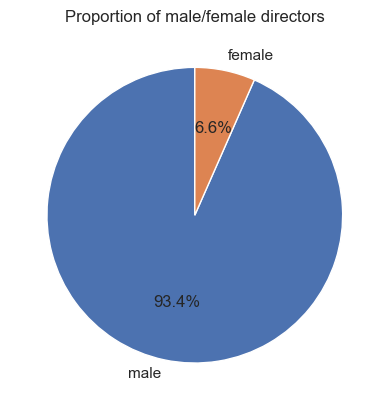

In [247]:
# Count the number of movies directed by each gender
only_directors = directors_movies_merge[directors_movies_merge['role'] == 'director']
gender_counts = only_directors['gender'].value_counts()

# Plot a pie chart
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of male/female directors')
plt.show()

In [248]:
# Calculate the proportions for each rating category for male directors
male_proportions = only_directors[only_directors['gender'] == 'male']['rating'].value_counts(normalize=True) * 100
female_proportions = only_directors[only_directors['gender'] == 'female']['rating'].value_counts(normalize=True) * 100

In [249]:
# Calculate the proportions for each rating category
directors_gender_prop = pd.merge(male_proportions, female_proportions, on=['rating'], how='outer')

/Users/mathisayma/anaconda3/envs/ADA/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



<Figure size 1200x600 with 0 Axes>

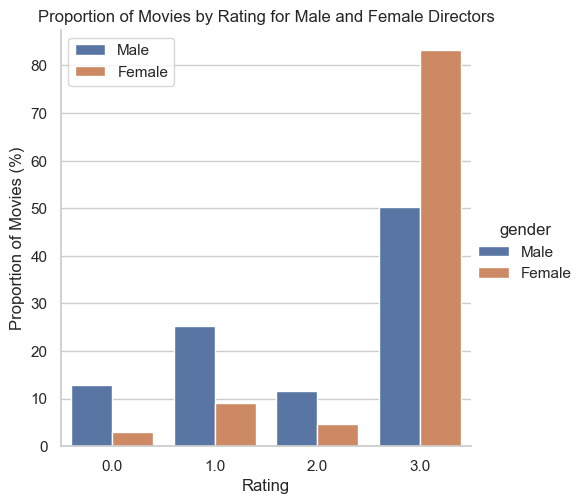

In [250]:
directors_gender_prop = directors_gender_prop.reset_index()

#Reset index and rename columns
directors_gender_prop = directors_gender_prop.rename(columns={ 'proportion_x': 'Male', 'proportion_y': 'Female'})
directors_gender_prop = pd.melt(directors_gender_prop, id_vars='rating', var_name='gender', value_name='proportion')


# Set up the plot
plt.figure(figsize=(12, 6))

# Plot for both male and female directors
sns.catplot(x='rating', y='proportion', hue='gender', data=directors_gender_prop, kind='bar', height=5, aspect=1)

plt.xlabel('Rating')
plt.ylabel('Proportion of Movies (%)')
plt.title('Proportion of Movies by Rating for Male and Female Directors')

plt.legend()
plt.show()

In [251]:
#Convert to HTML
directors_gender_prop.reset_index(drop=True, inplace=True)  # Reset index without keeping the old index

# Drop unnecessary columns
directors_gender_prop = directors_gender_prop[['rating', 'gender', 'proportion']]

# Set custom colors
color_discrete_map = {'Male': '#FFD700', 'Female': '#B19CD9'}

# Create a bar plot using Plotly Express
fig = px.bar(directors_gender_prop, x='rating', y='proportion', color='gender',
             labels={'proportion': 'Proportion of Movies (%)'},
             title='Proportion of Movies by Rating for Male and Female Directors',
             height=500, width=800,
             color_discrete_map=color_discrete_map, barmode='group')  # Set barmode to 'group' for bars next to each other

# Set x-axis tick values as discrete
fig.update_xaxes(type='category')

# Show the plot
fig.show()

# Save the plot as an HTML file
fig.write_html('movies_directors.html')

For female directors, the films they make pass the Bechdel test in more than 80% of cases. For male directors, the films they make pass the Bechdel test in only 50% of cases. Additionally, more than 10% of male directors make films that do not satisfy any of the conditions of the test.

### proportion of female writers in cinema industry

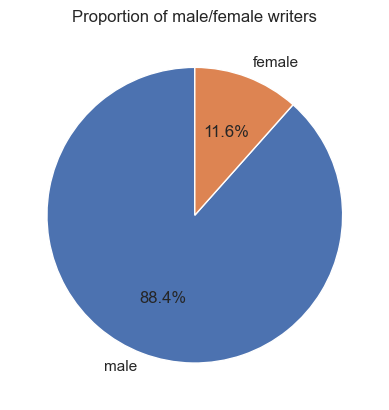

In [252]:
# Count the number of movies written by each gender
only_writers = directors_movies_merge[directors_movies_merge['role'] == 'writer']

# Count the number of movies written by each gender
gender_counts = only_writers['gender'].value_counts()

# Plot a pie chart
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of male/female writers')
plt.show()

/Users/mathisayma/anaconda3/envs/ADA/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



<Figure size 1200x600 with 0 Axes>

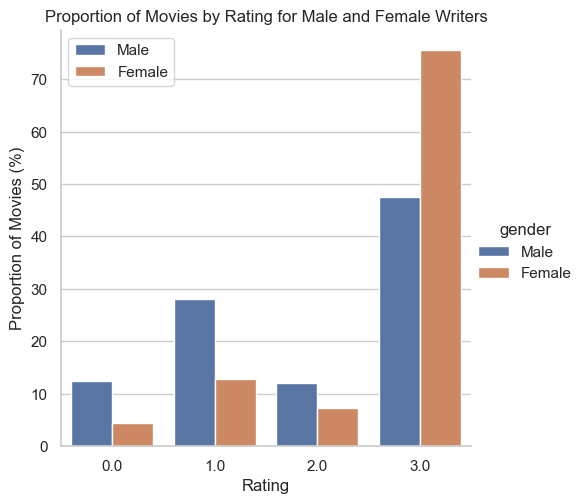

In [253]:
# Calculate the proportions for each rating category for male writers
male_proportions = only_writers[only_writers['gender'] == 'male']['rating'].value_counts(normalize=True) * 100
female_proportions = only_writers[only_writers['gender'] == 'female']['rating'].value_counts(normalize=True) * 100

# Calculate the proportions for each rating category
writers_gender_prop = pd.merge(male_proportions, female_proportions, on=['rating'], how='outer')
writers_gender_prop = writers_gender_prop.reset_index()

#Reset index and rename columns
writers_gender_prop = writers_gender_prop.rename(columns={ 'proportion_x': 'Male', 'proportion_y': 'Female'})
writers_gender_prop = pd.melt(writers_gender_prop, id_vars='rating', var_name='gender', value_name='proportion')


# Set up the plot
plt.figure(figsize=(12, 6))

# Plot for both male and female writers
sns.catplot(x='rating', y='proportion', hue='gender', data=writers_gender_prop, kind='bar', height=5, aspect=1)

plt.xlabel('Rating')
plt.ylabel('Proportion of Movies (%)')
plt.title('Proportion of Movies by Rating for Male and Female Writers')

plt.legend()
plt.show()

The plot is quite similar to the one for directors

In [254]:
count_rating0 = len(only_writers[only_writers['rating'] == 0])/len(only_writers)
count_rating1 = len(only_writers[only_writers['rating'] == 1])/len(only_writers)
count_rating2 = len(only_writers[only_writers['rating'] == 2])/len(only_writers)
count_rating3 = len(only_writers[only_writers['rating'] == 3])/len(only_writers)
print('proportion of movies writers where movies pass 0 test :', count_rating0 )
print('proportion of movies writers where movies pass 1 test :', count_rating1 )
print('proportion of movies writers where movies pass 2 test :', count_rating2 )
print('proportion of movies writers where movies pass 3 test :', count_rating3 )

proportion of movies writers where movies pass 0 test : 0.11513571813769549
proportion of movies writers where movies pass 1 test : 0.2628977170591408
proportion of movies writers where movies pass 2 test : 0.11486607945353226
proportion of movies writers where movies pass 3 test : 0.5071004853496315


### writers and directors in the top 100 highest grossing films in the data frame

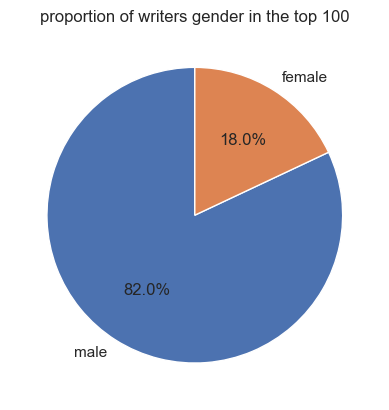

In [255]:
only_writers_100 = only_writers.sort_values(by='Movie box office revenue', ascending=False).head(100)

# Count the number of movies written by each gender
gender_counts = only_writers_100['gender'].value_counts()

# Plot a pie chart
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('proportion of writers gender in the top 100')
plt.show()

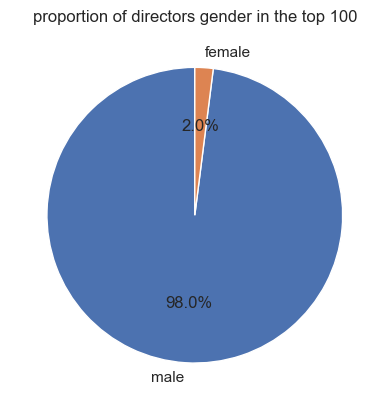

In [256]:
only_directors_100 = only_directors.sort_values(by='Movie box office revenue', ascending=False).head(100)

# Count the number of movies directed by each gender
gender_counts = only_directors_100['gender'].value_counts()

# Plot a pie chart
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('proportion of directors gender in the top 100')
plt.show()

### Now, we want to determine, for each film, the proportions of female directors and writers.

In [257]:
gender_counts = only_directors.groupby('movie_wiki_id')['gender'].value_counts().unstack()
# Calculate the proportion of female and male actors for each movie
gender_proportion = gender_counts.div(gender_counts.sum(axis=1), axis=0)

# Add the proportion columns to the original dataframe
only_directors = only_directors.merge(gender_proportion, left_on='movie_wiki_id', right_index=True, how='left')
only_directors.rename(columns={'female': 'female_director_proportion', 'male': 'male_director_proportion'}, inplace=True)

#Calculate the number of female and male actors for each movie
gender_counts2 = only_directors.groupby(['movie_wiki_id', 'pass_Bechdel'])['gender'].value_counts().unstack(fill_value=0)
gender_counts2.columns = ['female_directors','male_directors']
gender_counts2.reset_index(inplace=True)

# Merge the calculated counts back to the original DataFrame
only_directors = pd.merge(only_directors, gender_counts2[['movie_wiki_id', 'pass_Bechdel', 'female_directors', 'male_directors']], on=['movie_wiki_id', 'pass_Bechdel'], how='left')
only_directors.head(3)

,title_x,movie_wiki_id,movie_freebase_id,movie_imdb_id,role,imdb_id,name,gender,birth,Unnamed: 0.1,...,genres,Production Company,result,genres_dict,genres_names,pass_Bechdel,female_director_proportion,male_director_proportion,female_directors,male_directors
0,Ghosts of Mars,975900,/m/03vyhn,tt0228333,director,nm0000118,John Carpenter,male,1948-01-16,3281.0,...,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",NaN,Pass,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","[LGBT, Indie, gay, gay, gay, Coming of age, Fi...",True,NaN,1.0,0,1
1,City of the Dead,2345652,/m/075f66,tt0053719,director,nm0610303,John Llewellyn Moxey,male,1925-02-26,824.0,...,"{'/m/03npn': 'Horror', '/m/0fdjb': 'Supernatur...",NaN,Pass,"{'/m/03npn': 'Horror', '/m/0fdjb': 'Supernatur...","[Japanese Movies, horror, world]",True,NaN,1.0,0,1
2,Henry V,171005,/m/016ywb,tt0097499,director,nm0000110,Kenneth Branagh,male,1960-12-10,2107.0,...,"{'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...",BBC,Pass,"{'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...","[costume, war, epic, period, Drama, Film adapt...",True,NaN,1.0,0,1


In [258]:
only_directors['pass_Bechdel']

0        True
1        True
2        True
3        True
4        True
        ...  
6075     True
6076     True
6077     True
6078    False
6079    False
Name: pass_Bechdel, Length: 6080, dtype: object

In [259]:
only_directors.shape

(6080, 37)

In [260]:
only_directors[only_directors['female_director_proportion']== 0.20]

,title_x,movie_wiki_id,movie_freebase_id,movie_imdb_id,role,imdb_id,name,gender,birth,Unnamed: 0.1,...,genres,Production Company,result,genres_dict,genres_names,pass_Bechdel,female_director_proportion,male_director_proportion,female_directors,male_directors
3343,Four Rooms,554858,/m/02pg45,tt0113101,director,nm0025978,Allison Anders,female,1954-11-16,2586.0,...,{'/m/01z4y': 'Comedy'},A Band Apart,Pass,{'/m/01z4y': 'Comedy'},[Comedy],True,0.2,0.8,1,4
3344,Four Rooms,554858,/m/02pg45,tt0113101,director,nm0734319,Alexandre Rockwell,male,1956-08-18,2586.0,...,{'/m/01z4y': 'Comedy'},A Band Apart,Pass,{'/m/01z4y': 'Comedy'},[Comedy],True,0.2,0.8,1,4
3345,Four Rooms,554858,/m/02pg45,tt0113101,director,nm0001675,Robert Rodriguez,male,1968-06-20,2586.0,...,{'/m/01z4y': 'Comedy'},A Band Apart,Pass,{'/m/01z4y': 'Comedy'},[Comedy],True,0.2,0.8,1,4
3346,Four Rooms,554858,/m/02pg45,tt0113101,director,nm0000233,Quentin Tarantino,male,1963-03-27,2586.0,...,{'/m/01z4y': 'Comedy'},A Band Apart,Pass,{'/m/01z4y': 'Comedy'},[Comedy],True,0.2,0.8,1,4
3347,Four Rooms,554858,/m/02pg45,tt0113101,director,nm0005062,Chuck Jones,male,1912-09-21,2586.0,...,{'/m/01z4y': 'Comedy'},A Band Apart,Pass,{'/m/01z4y': 'Comedy'},[Comedy],True,0.2,0.8,1,4


In [261]:
movie_grouped_directors = only_directors.groupby('movie_wiki_id')
# Drop duplicate rows based on 'movie_wiki_id' and 'title_x'
movie_grouped_directors = only_directors.drop_duplicates(subset=['movie_wiki_id', 'title_x'])
movie_grouped_directors = movie_grouped_directors.reset_index(drop=True)
movie_grouped_directors.shape

(5483, 37)

In [262]:
movie_grouped_directors[movie_grouped_directors['female_director_proportion']== 0.20]

,title_x,movie_wiki_id,movie_freebase_id,movie_imdb_id,role,imdb_id,name,gender,birth,Unnamed: 0.1,...,genres,Production Company,result,genres_dict,genres_names,pass_Bechdel,female_director_proportion,male_director_proportion,female_directors,male_directors
3010,Four Rooms,554858,/m/02pg45,tt0113101,director,nm0025978,Allison Anders,female,1954-11-16,2586.0,...,{'/m/01z4y': 'Comedy'},A Band Apart,Pass,{'/m/01z4y': 'Comedy'},[Comedy],True,0.2,0.8,1,4


We can compute the different values we find for the proportion of female directors and how many times we find each proportion

In [263]:
movie_grouped_directors['female_director_proportion'].fillna(0, inplace=True)
movie_grouped_directors['male_director_proportion'].fillna(0, inplace=True)
unique_female_directors_values = movie_grouped_directors['female_director_proportion'].unique()
print('different values for proportion of female directors', unique_female_directors_values)
unique_male_directors_values = movie_grouped_directors['male_director_proportion'].unique()
print('complementary values for proportion of male directors', unique_male_directors_values)

different values for proportion of female directors [0.         1.         0.5        0.33333333 0.2        0.25      ]
complementary values for proportion of male directors [1.         0.         0.5        0.66666667 0.8        0.75      ]


In [264]:
# Count the occurrences of each unique value in 'female_director_proportion'
female_director_counts = movie_grouped_directors['female_director_proportion'].value_counts()
print(female_director_counts)

female_director_proportion
0.000000    5091
1.000000     361
0.500000      26
0.333333       3
0.200000       1
0.250000       1
Name: count, dtype: int64


/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/420098075.py:1: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/Users/mathisayma/anaconda3/envs/ADA/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



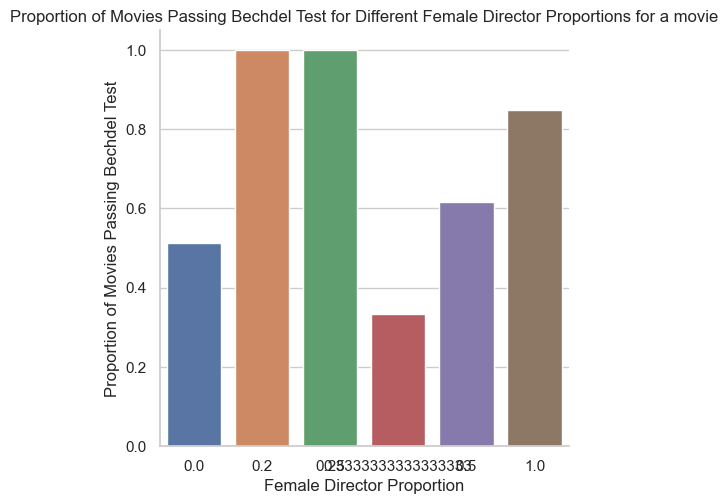

In [265]:
sns.catplot(x='female_director_proportion', y='pass_Bechdel', data=movie_grouped_directors, kind='bar', ci=None)
plt.xlabel('Female Director Proportion')
plt.ylabel('Proportion of Movies Passing Bechdel Test')
plt.title('Proportion of Movies Passing Bechdel Test for Different Female Director Proportions for a movie')
plt.show()

This graph is not representative because, as we saw just above, some proportions of female directors account for only 1 or 3 films, as is the case for 0.33, 0.25, and 0.20. However, we can see that the 26 movies with a cast of However, we can see when half of the directors are women, movies pass the test in more than 60% of cases.

In [266]:
# Filter the DataFrame for rows where 'female_director_proportion' is equal to 1 and 'pass_Bechdel' is True
filtered_data = movie_grouped_directors[(movie_grouped_directors['female_director_proportion'] == 1) & (movie_grouped_directors['pass_Bechdel'] == True)]

# Calculate the percentage
percentage_pass_bechdel = (len(filtered_data) / len(movie_grouped_directors[movie_grouped_directors['female_director_proportion'] == 1])) * 100
print(f"Percentage of movies with female_director_proportion=1 that pass the Bechdel test: {percentage_pass_bechdel:.2f}%")

Percentage of movies with female_director_proportion=1 that pass the Bechdel test: 84.76%


In [267]:
#Filter the DataFrame for rows where 'female_director_proportion' is equal to 0 and 'pass_Bechdel' is True
filtered_data = movie_grouped_directors[(movie_grouped_directors['female_director_proportion'] == 0) & (movie_grouped_directors['pass_Bechdel'] == True)]

# Calculate the percentage
percentage_pass_bechdel = (len(filtered_data) / len(movie_grouped_directors[movie_grouped_directors['female_director_proportion'] == 0])) * 100
print(f"Percentage of movies with female_director_proportion=0 that pass the Bechdel test: {percentage_pass_bechdel:.2f}%")

Percentage of movies with female_director_proportion=0 that pass the Bechdel test: 51.23%


In [268]:
#Group by 'Wikipedia movie ID' and count the occurrences of each gender
gender_counts = only_writers.groupby('movie_wiki_id')['gender'].value_counts().unstack()

# Calculate the proportion of female and male actors for each movie
gender_proportion = gender_counts.div(gender_counts.sum(axis=1), axis=0)

# Add the proportion columns to the original dataframe
only_writers = only_writers.merge(gender_proportion, left_on='movie_wiki_id', right_index=True, how='left')
only_writers.rename(columns={'female': 'female_writer_proportion', 'male': 'male_writer_proportion'}, inplace=True)

#Calculate the number of female and male actors for each movie
gender_counts2 = only_writers.groupby(['movie_wiki_id', 'pass_Bechdel'])['gender'].value_counts().unstack(fill_value=0)
gender_counts2.columns = ['female_writers','male_writers']
gender_counts2.reset_index(inplace=True)

# Merge the calculated counts back to the original DataFrame
only_writers = pd.merge(only_writers, gender_counts2[['movie_wiki_id', 'pass_Bechdel', 'female_writers', 'male_writers']], on=['movie_wiki_id', 'pass_Bechdel'], how='left')

In [269]:
movie_grouped_writers = only_writers.groupby('movie_wiki_id')
# Drop duplicate rows based on 'movie_wiki_id' and 'title_x'
movie_grouped_writers = only_writers.drop_duplicates(subset=['movie_wiki_id', 'title_x'])

# If you want to reset the index of the new DataFrame
movie_grouped_writers = movie_grouped_writers.reset_index(drop=True)

In [270]:
movie_grouped_writers['female_writer_proportion'].fillna(0, inplace=True)
movie_grouped_writers['male_writer_proportion'].fillna(0, inplace=True)
unique_female_writers_values = movie_grouped_writers['female_writer_proportion'].unique()
print('all different values possible for the proportion of female writer proprtion for a movie')
print(unique_female_writers_values)

all different values possible for the proportion of female writer proprtion for a movie
[0.         0.66666667 0.5        0.16666667 1.         0.33333333
 0.2        0.28571429 0.09090909 0.125      0.0625     0.25
 0.08333333 0.75       0.14285714 0.6        0.11111111 0.3
 0.375      0.07142857 0.41666667 0.4        0.22222222]


In [271]:
# Count the occurrences of each unique value in 'female_writer_proportion'
female_writer_counts = movie_grouped_writers['female_writer_proportion'].value_counts()
print(female_writer_counts)

female_writer_proportion
0.000000    4276
1.000000     388
0.500000     325
0.333333     155
0.250000      76
0.200000      35
0.666667      35
0.166667      16
0.142857      11
0.400000       7
0.750000       4
0.125000       3
0.375000       3
0.600000       3
0.285714       3
0.222222       2
0.071429       2
0.090909       2
0.062500       1
0.083333       1
0.111111       1
0.300000       1
0.416667       1
Name: count, dtype: int64


Once again, many values are not really representatives, we can keep only the proportion of female writers with more than 100 movies in it

/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/3367428589.py:10: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/Users/mathisayma/anaconda3/envs/ADA/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



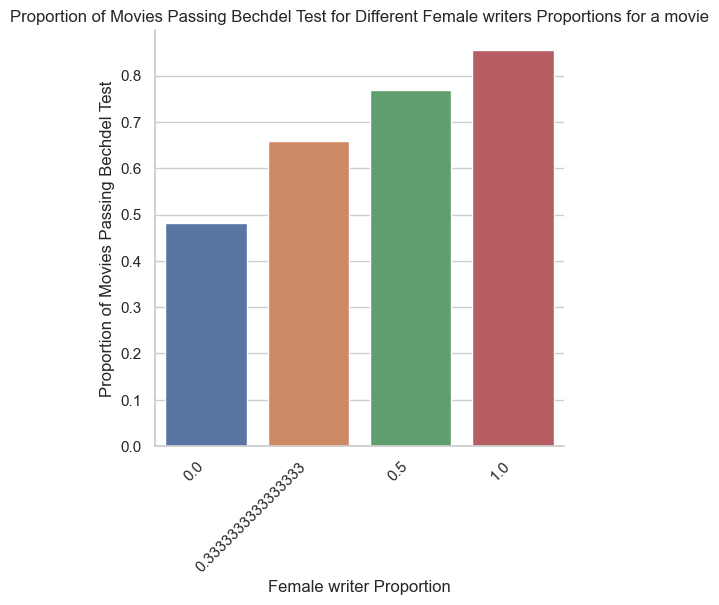

In [272]:
counts = movie_grouped_writers['female_writer_proportion'].value_counts()

# Filter only the values with counts greater than 100
filtered_values = counts[counts > 100].index

# Filter the DataFrame based on the selected values
filtered_data = movie_grouped_writers[movie_grouped_writers['female_writer_proportion'].isin(filtered_values)]

# Plot the filtered data
sns.catplot(x='female_writer_proportion', y='pass_Bechdel', data=filtered_data, kind='bar', ci=None)
plt.xlabel('Female writer Proportion')
plt.ylabel('Proportion of Movies Passing Bechdel Test')
plt.title('Proportion of Movies Passing Bechdel Test for Different Female writers Proportions for a movie')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to see all values
plt.show()

Now we merge the two data frame movie_grouped_writers and movie_grouped_directors in the first one from the beggning to have only for new columns the proportion of female directors and writers (and their number)

In [273]:
# Merge the DataFrames based on common columns
movies_writers_director = pd.merge(movie_grouped_directors, movie_grouped_writers[['title_x', 'movie_wiki_id', 'rating', 'genres', 'Production Company', 'female_writer_proportion', 'male_writer_proportion', 'female_writers', 'male_writers']],
                                   on=['title_x', 'movie_wiki_id', 'rating', 'Production Company'],
                                   how='left')
movies_writers_director.head(5)

,title_x,movie_wiki_id,movie_freebase_id,movie_imdb_id,role,imdb_id,name,gender,birth,Unnamed: 0.1,...,pass_Bechdel,female_director_proportion,male_director_proportion,female_directors,male_directors,genres_y,female_writer_proportion,male_writer_proportion,female_writers,male_writers
0,Ghosts of Mars,975900,/m/03vyhn,tt0228333,director,nm0000118,John Carpenter,male,1948-01-16,3281.0,...,True,0.0,1.0,0,1,"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",0.000000,1.000000,0.0,1.0
1,City of the Dead,2345652,/m/075f66,tt0053719,director,nm0610303,John Llewellyn Moxey,male,1925-02-26,824.0,...,True,0.0,1.0,0,1,"{'/m/03npn': 'Horror', '/m/0fdjb': 'Supernatur...",0.000000,1.000000,0.0,2.0
2,Henry V,171005,/m/016ywb,tt0097499,director,nm0000110,Kenneth Branagh,male,1960-12-10,2107.0,...,True,0.0,1.0,0,1,"{'/m/04xvh5': 'Costume drama', '/m/082gq': 'Wa...",0.000000,1.000000,0.0,1.0
3,Mary Poppins,77856,/m/0kcn7,tt0058331,director,nm0829038,Robert Stevenson,male,1905-03-31,948.0,...,True,0.0,1.0,0,1,"{'/m/0hj3myq': 'Children's/Family', '/m/04t36'...",0.000000,1.000000,0.0,2.0
4,Loverboy,12053509,/m/02vn81r,tt0097790,director,nm0798717,Joan Micklin Silver,female,1935-05-24,2131.0,...,True,1.0,0.0,1,0,"{'/m/06cvj': 'Romantic comedy', '/m/02l7c8': '...",0.666667,0.333333,2.0,1.0


In [274]:
# Filter the DataFrame based on the conditions
filtered_rows = movies_writers_director[(movies_writers_director['female_writer_proportion'] == 0) & (movies_writers_director['female_director_proportion'] == 0)]

# Calculate the percentage of movies passing the Bechdel test
percentage_pass_bechdel = filtered_rows['pass_Bechdel'].mean() * 100

# Display the result
print(f"Percentage of movies with female_writer_proportion==0 and female_director_proportion==0 that pass the Bechdel test: {percentage_pass_bechdel:.2f}%")

Percentage of movies with female_writer_proportion==0 and female_director_proportion==0 that pass the Bechdel test: 47.92%


Here we plot together the female writers/directors proportion for each decade with enough movies (>100) and the proportion of movies in this decade that pass the Bechdel test

In [275]:
# Convert 'year_x' to decade
movies_writers_director['decade'] = (movies_writers_director['year_x'] // 10) * 10
# Count the number of values for each decade
decade_counts = movies_writers_director['decade'].value_counts().sort_index()
print(decade_counts)

decade
1870.0       1
1880.0       1
1890.0      26
1900.0      14
1910.0      17
1920.0      67
1930.0     176
1940.0     210
1950.0     244
1960.0     334
1970.0     384
1980.0     573
1990.0     933
2000.0    1733
2010.0     768
2020.0       2
Name: count, dtype: int64


/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gn/T/ipykernel_42572/2060950373.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



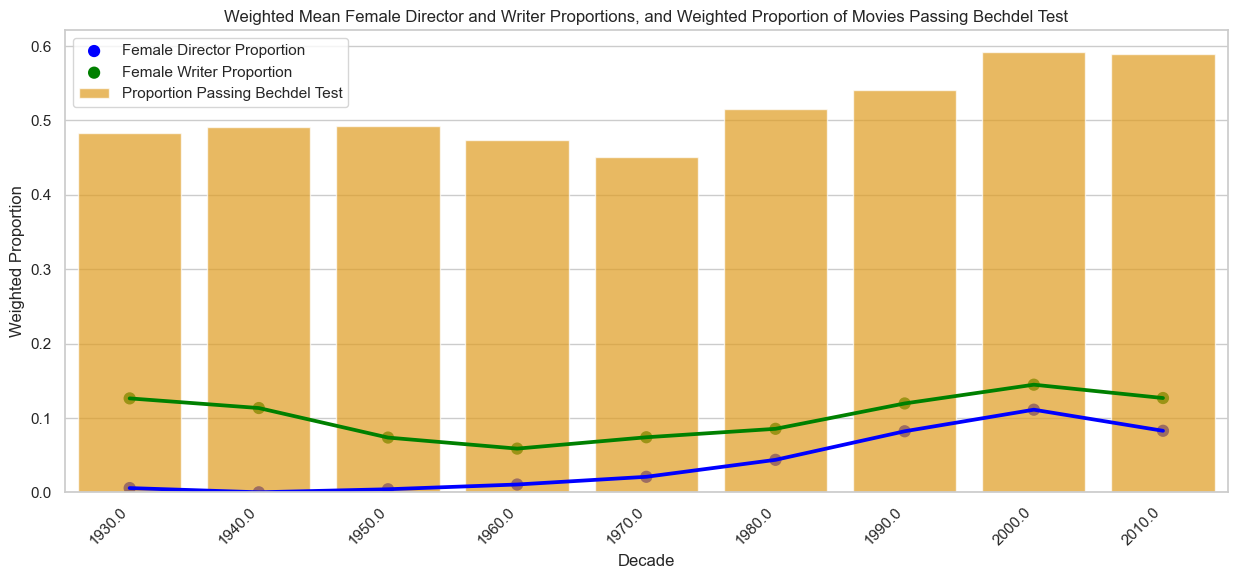

In [276]:
# Exclude the decades with not enough data
excluded_decades = [1870, 1880, 1890, 1900, 1910, 1920, 2020]
filtered_data = movies_writers_director[~movies_writers_director['decade'].isin(excluded_decades)]

# Calculate the number of movies in each decade
filtered_data['num_movies'] = filtered_data.groupby('decade')['movie_wiki_id'].transform('count')
sns.set(style="whitegrid")

# Create a figure and axes
plt.figure(figsize=(15, 6))

# Calculate the weighted mean of female_director_proportion
weighted_female_director = (filtered_data['female_director_proportion'] * filtered_data['num_movies']).groupby(filtered_data['decade']).sum() / filtered_data.groupby('decade')['num_movies'].sum()
# Plot the weighted mean of female_director_proportion
sns.pointplot(x=weighted_female_director.index, y=weighted_female_director.values, color='blue', label='Female Director Proportion')

# Calculate the weighted mean of female_writer_proportion
weighted_female_writer = (filtered_data['female_writer_proportion'] * filtered_data['num_movies']).groupby(filtered_data['decade']).sum() / filtered_data.groupby('decade')['num_movies'].sum()
# Plot the weighted mean of female_writer_proportion
sns.pointplot(x=weighted_female_writer.index, y=weighted_female_writer.values, color='green', label='Female Writer Proportion')

# Calculate the weighted proportion of movies passing Bechdel test
weighted_pass_bechdel = (filtered_data['pass_Bechdel'] * filtered_data['num_movies']).groupby(filtered_data['decade']).sum() / filtered_data.groupby('decade')['num_movies'].sum()
# Plot the weighted proportion of movies passing Bechdel test
sns.barplot(x=weighted_pass_bechdel.index, y=weighted_pass_bechdel.values, color='orange', alpha=0.7, label='Proportion Passing Bechdel Test')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set labels and title
plt.xlabel('Decade')
plt.ylabel('Weighted Proportion')
plt.title('Weighted Mean Female Director and Writer Proportions, and Weighted Proportion of Movies Passing Bechdel Test')

# Add legend
plt.legend()

# Display the plot
plt.show()

In [277]:
movies_writers_director.loc[
    (movies_writers_director['decade'] == 1930) & 
    (movies_writers_director['female_writers'] == 1),
    ['decade', 'female_writers', 'pass_Bechdel']
]

,decade,female_writers,pass_Bechdel
46,1930.0,1.0,True
273,1930.0,1.0,True
375,1930.0,1.0,True
489,1930.0,1.0,False
490,1930.0,1.0,True
697,1930.0,1.0,False
790,1930.0,1.0,True
1041,1930.0,1.0,True
1047,1930.0,1.0,True
1202,1930.0,1.0,False


In [278]:
prop_1930 = len(movies_writers_director.loc[
    (movies_writers_director['decade'] == 1930) & 
    (movies_writers_director['female_writers'] != 0) & (movies_writers_director['pass_Bechdel'] == True),
    ['decade', 'female_writers', 'pass_Bechdel']
])/len(movies_writers_director.loc[
    (movies_writers_director['decade'] == 1930) & 
    (movies_writers_director['female_writers'] != 0),
    ['decade', 'female_writers', 'pass_Bechdel']
]) 
print('Proportion of movies among those written by women that pass the Bechdel test for the 1930s decade:', prop_1930)

Proportion of movies among those written by women that pass the Bechdel test for the 1930s decade: 0.6666666666666666


/Users/mathisayma/anaconda3/envs/ADA/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



<Figure size 1000x600 with 0 Axes>

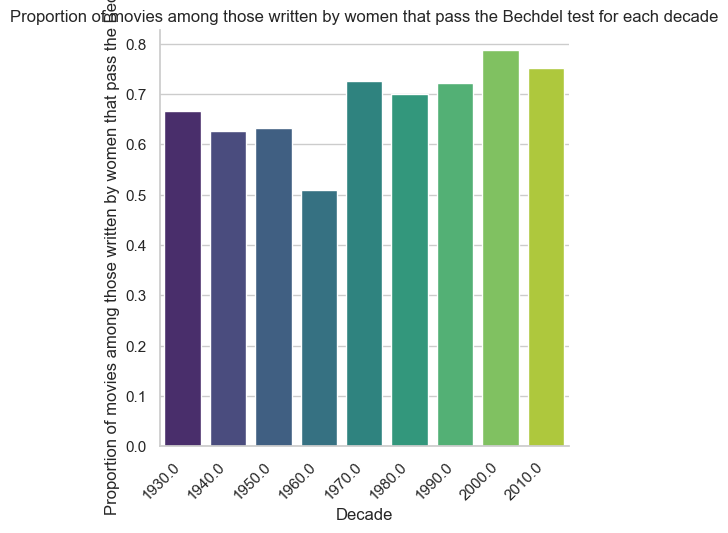

In [149]:
unique_decades = filtered_data['decade'].unique()
prop_decade = []

# Loop through each unique decade
for current_decade in unique_decades:
    prop = len(movies_writers_director.loc[
        (movies_writers_director['decade'] == current_decade) & 
        (movies_writers_director['female_writers'] != 0) & (movies_writers_director['pass_Bechdel'] == True),
        ['decade', 'female_writers', 'pass_Bechdel']
    ]) / len(movies_writers_director.loc[
        (movies_writers_director['decade'] == current_decade) & 
        (movies_writers_director['female_writers'] != 0),
        ['decade', 'female_writers', 'pass_Bechdel']
    ])
    
    # Append the proportion to the list
    prop_decade.append(prop)

# Create a dataframe for seaborn

df_ = pd.DataFrame({'Decade': unique_decades, 'Proportion': prop_decade})

# Plotting a catplot
plt.figure(figsize=(10, 6))
sns.catplot(x='Decade', y='Proportion', data=df_, kind='bar', palette='viridis')
plt.xlabel('Decade')
plt.ylabel('Proportion of movies among those written by women that pass the Bechdel')
plt.title('Proportion of movies among those written by women that pass the Bechdel test for each decade')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to see all values
plt.show()